# 1. Импорт необходимых библиотек

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates #Date Parser
import seaborn as sns
import warnings
from pylab import rcParams
import sktime
from tsai.all import *
import torch
from torch import nn

from sklearn.model_selection import train_test_split
from IPython.display import clear_output

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tools.sm_exceptions import ConvergenceWarning

from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import (
    EnsembleForecaster,
    make_reduction
)
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.naive import NaiveForecaster
from sktime.performance_metrics.forecasting import  MeanAbsolutePercentageError, MeanSquaredError
from sktime.split import temporal_train_test_split
from sktime.utils.plotting import plot_series
from sktime.forecasting.fbprophet import Prophet
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sktime.classification.shapelet_based import ShapeletTransformClassifier
from sktime.classification.interval_based import   SupervisedTimeSeriesForest
from sktime.classification.dictionary_based import MUSE
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.sarimax import SARIMAX
from sktime.forecasting.arima import AutoARIMA
from sktime.datatypes import convert_to

# 2. Настройка параметров

In [48]:
pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", 20)
pd.set_option("display.precision",6)
pd.set_option("plotting.backend", "matplotlib")
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter("ignore")

#Для корректного отображения графиков в ноутбуках используется команда %matplotlib inline
%matplotlib inline
# для корректного отображения графиков на тёмном фоне
plt.style.use('default')

sns.set(rc={'figure.figsize':(20, 5)})

# 3. Код (вспомогательные методы)

In [3]:
# Порог для критерия стационарности
P_THRESHOLD = 0.05

#Столбец, с которым выполняется вся работа в ноутбуке
COLS_MAP = {'load_actual_entsoe_transparency' : 'Consumption'}

RANDOM_SEED = np.random.seed(0)

def extract_country(df_all, country_code, year_min=None, year_max=None):
    """Extract data for a single country"""

    # List of columns to extract
    columns = [col for col in df_all.columns if col.startswith(country_code)]

    # Extract columns and remove country codes from column labels
    columns_map = {col : col[3:] for col in columns}
    df_out = df_all[columns].rename(columns=columns_map)

    # Exclude years outside of specified range, if any
    if year_min is not None:
        df_out = df_out[df_out.index.year >= year_min]
    if year_max is not None:
        df_out = df_out[df_out.index.year <= year_max]

    return df_out

def transform_dataframe(source_df, cols_map=COLS_MAP):
    # Rename columns for convenience
    new_df = source_df[list(cols_map.keys())].rename(columns=cols_map)
    # Convert from MW to GW
    new_df = new_df / 1000
    new_df = new_df.resample('D').sum(min_count=24)
    new_df = new_df.rename_axis('Date')
    new_df.index = new_df.index.strftime('%Y-%m-%d')
    return new_df

def transform_dataframe_by_day(source_df, cols_map=COLS_MAP):
    # Rename columns for convenience
    new_df = source_df[list(cols_map.keys())].rename(columns=cols_map)
    # Convert from MW to GW
    new_df = new_df / 1000
    new_df = new_df.rename_axis('Date')
    return new_df

def check_ADF(y, p_threshold = P_THRESHOLD):
    result = adfuller(y)
    adf_value = result[0]
    p_value   = result[1]
    print('ADF Statistic: {:.4f}'.format(adf_value))
    print('p-value: {:.4f}'.format(p_value))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {:.4f}, {}'.format(key, value, 'outperformed' if adf_value>value else ""))
    print(f'Вывод: ряд {"не" if p_value < p_threshold else ""}стационарен')
    return result

def to_segments(source_df, column, size = 24):
    start_idx = 24-source_df.index.hour[0]
    new_df = source_df.iloc[start_idx:]
    val = new_df[[column]].values
    return val[:size*(val.size//size)].reshape(-1,size)

def split_by_month(source_df, months):
    new_df = pd.DataFrame()
    for month in np.atleast_1d(months):
        new_df = pd.concat((new_df, source_df.loc[source_df.index.month == month]), axis=0)
    return new_df

r2_score = lambda y_pred, y_test: 1-np.sum(np.square(y_pred - y_test))/np.sum(np.square(y_test - np.mean(y_test)))

smape = MeanAbsolutePercentageError(symmetric = True)
rmse  = MeanSquaredError(square_root=True)

# 4. Загрузка и подготовка данных

## 4.1. Загрузка данных

In [4]:
# Download hourly data from OPSD website
remote_uri = 'https://data.open-power-system-data.org/time_series/2020-10-06/'
local_uri = './data/'
datafile = local_uri + 'time_series_60min_singleindex.csv'
df_all = pd.read_csv(datafile, index_col='utc_timestamp', parse_dates=True, low_memory=False)

In [5]:
df_all.head()

cet_cest_timestamp  \
utc_timestamp                                         
2014-12-31 23:00:00+00:00  2015-01-01T00:00:00+0100   
2015-01-01 00:00:00+00:00  2015-01-01T01:00:00+0100   
2015-01-01 01:00:00+00:00  2015-01-01T02:00:00+0100   
2015-01-01 02:00:00+00:00  2015-01-01T03:00:00+0100   
2015-01-01 03:00:00+00:00  2015-01-01T04:00:00+0100   

                           AT_load_actual_entsoe_transparency  \
utc_timestamp                                                   
2014-12-31 23:00:00+00:00                                 NaN   
2015-01-01 00:00:00+00:00                              5946.0   
2015-01-01 01:00:00+00:00                              5726.0   
2015-01-01 02:00:00+00:00                              5347.0   
2015-01-01 03:00:00+00:00                              5249.0   

                           AT_load_forecast_entsoe_transparency  \
utc_timestamp                                                     
2014-12-31 23:00:00+00:00                                   NaN   
2015-01-01 00:00:00+00:00                                6701.0   
2015-01-01 01:00:00+00:00                                6593.0   
2015-01-01 02:00:00+00:00                                6482.0   
2015-01-01 03:00:00+00:00                                6454.0   

                           AT_price_day_ahead  AT_solar_generation_actual  \
utc_timestamp                                                               
2014-12-31 23:00:00+00:00                 NaN                         NaN   
2015-01-01 00:00:00+00:00                35.0                         NaN   
2015-01-01 01:00:00+00:00                45.0                         NaN   
2015-01-01 02:00:00+00:00                41.0                         NaN   
2015-01-01 03:00:00+00:00                38.0                         NaN   

                           AT_wind_onshore_generation_actual  \
utc_timestamp                                                  
2014-12-31 23:00:00+00:00                                NaN   
2015-01-01 00:00:00+00:00                               69.0   
2015-01-01 01:00:00+00:00                               64.0   
2015-01-01 02:00:00+00:00                               65.0   
2015-01-01 03:00:00+00:00                               64.0   

                           BE_load_actual_entsoe_transparency  \
utc_timestamp                                                   
2014-12-31 23:00:00+00:00                                 NaN   
2015-01-01 00:00:00+00:00                              9484.0   
2015-01-01 01:00:00+00:00                              9152.0   
2015-01-01 02:00:00+00:00                              8799.0   
2015-01-01 03:00:00+00:00                              8567.0   

                           BE_load_forecast_entsoe_transparency  \
utc_timestamp                                                     
2014-12-31 23:00:00+00:00                                   NaN   
2015-01-01 00:00:00+00:00                                9897.0   
2015-01-01 01:00:00+00:00                                9521.0   
2015-01-01 02:00:00+00:00                                9135.0   
2015-01-01 03:00:00+00:00                                8909.0   

                           BE_solar_generation_actual  \
utc_timestamp                                           
2014-12-31 23:00:00+00:00                         NaN   
2015-01-01 00:00:00+00:00                         NaN   
2015-01-01 01:00:00+00:00                         NaN   
2015-01-01 02:00:00+00:00                         NaN   
2015-01-01 03:00:00+00:00                         NaN   

                           BE_wind_generation_actual  ...  \
utc_timestamp                                         ...   
2014-12-31 23:00:00+00:00                        NaN  ...   
2015-01-01 00:00:00+00:00                        NaN  ...   
2015-01-01 01:00:00+00:00                     734.81  ...   
2015-01-01 02:00:00+00:00                     766.64  ...   
2015-01-01 03:00:00+00:00               

## 4.2. Подготовка данных

Отбираем нужные данные

'AT_load_actual_entsoe_transparency'
DE_amprion_load_actual_entsoe_transparency
DE_tennet_load_actual_entsoe_transparency
BE_load_actual_entsoe_transparency


Выбор страны и периода - Austria, 2016-2020 гг

In [6]:
df_hrly = extract_country(df_all, country_code='AT', year_min=2015, year_max=2019)
df_hrly.head()

load_actual_entsoe_transparency  \
utc_timestamp                                                
2015-01-01 00:00:00+00:00                           5946.0   
2015-01-01 01:00:00+00:00                           5726.0   
2015-01-01 02:00:00+00:00                           5347.0   
2015-01-01 03:00:00+00:00                           5249.0   
2015-01-01 04:00:00+00:00                           5309.0   

                           load_forecast_entsoe_transparency  price_day_ahead  \
utc_timestamp                                                                   
2015-01-01 00:00:00+00:00                             6701.0             35.0   
2015-01-01 01:00:00+00:00                             6593.0             45.0   
2015-01-01 02:00:00+00:00                             6482.0             41.0   
2015-01-01 03:00:00+00:00                             6454.0             38.0   
2015-01-01 04:00:00+00:00                             6609.0             35.0   

                           solar_generation_actual  \
utc_timestamp                                        
2015-01-01 00:00:00+00:00                      NaN   
2015-01-01 01:00:00+00:00                      NaN   
2015-01-01 02:00:00+00:00                      NaN   
2015-01-01 03:00:00+00:00                      NaN   
2015-01-01 04:00:00+00:00                      NaN   

                           wind_onshore_generation_actual  
utc_timestamp                                              
2015-01-01 00:00:00+00:00                            69.0  
2015-01-01 01:00:00+00:00                            64.0  
2015-01-01 02:00:00+00:00                            65.0  
2015-01-01 03:00:00+00:00                            64.0  
2015-01-01 04:00:00+00:00                            64.0

Выбор столбца "load_actual_entsoe_transparency" - Total load in Austria in MW as published on ENTSO-E Transparency
Platform (Общая нагрузка в Австрии в МВт, опубликованная на платформе прозрачности ENTSO-E).
Преобразование данных

In [7]:
df = transform_dataframe(df_hrly)
df.to_csv('data.csv')
df.head()

Consumption
Date                   
2015-01-01      151.030
2015-01-02      138.923
2015-01-03      130.691
2015-01-04      125.123
2015-01-05      162.381

Введение индексов-дат

In [8]:
df.reset_index(inplace= True )
df['Date'] = pd.to_datetime(df.Date)
df.set_index('Date', inplace=True)
df.sample(15, random_state=0)

Consumption
Date                   
2017-03-04      161.004
2017-02-28      196.969
2015-04-29      169.546
2015-11-15      142.102
2017-06-10      140.158
2017-06-03      139.305
2015-12-14      200.029
2019-10-15      177.017
2016-04-27      185.907
2015-01-07      174.634
2017-01-14      189.202
2019-08-17      137.116
2019-02-06      211.609
2015-07-11      141.315
2017-06-23      175.012

Индексы

In [9]:
df.index

DatetimeIndex(['2015-01-01', '2015-01-02', '2015-01-03', '2015-01-04',
               '2015-01-05', '2015-01-06', '2015-01-07', '2015-01-08',
               '2015-01-09', '2015-01-10',
               ...
               '2019-12-22', '2019-12-23', '2019-12-24', '2019-12-25',
               '2019-12-26', '2019-12-27', '2019-12-28', '2019-12-29',
               '2019-12-30', '2019-12-31'],
              dtype='datetime64[ns]', name='Date', length=1826, freq=None)

# 5. Предварительный анализ

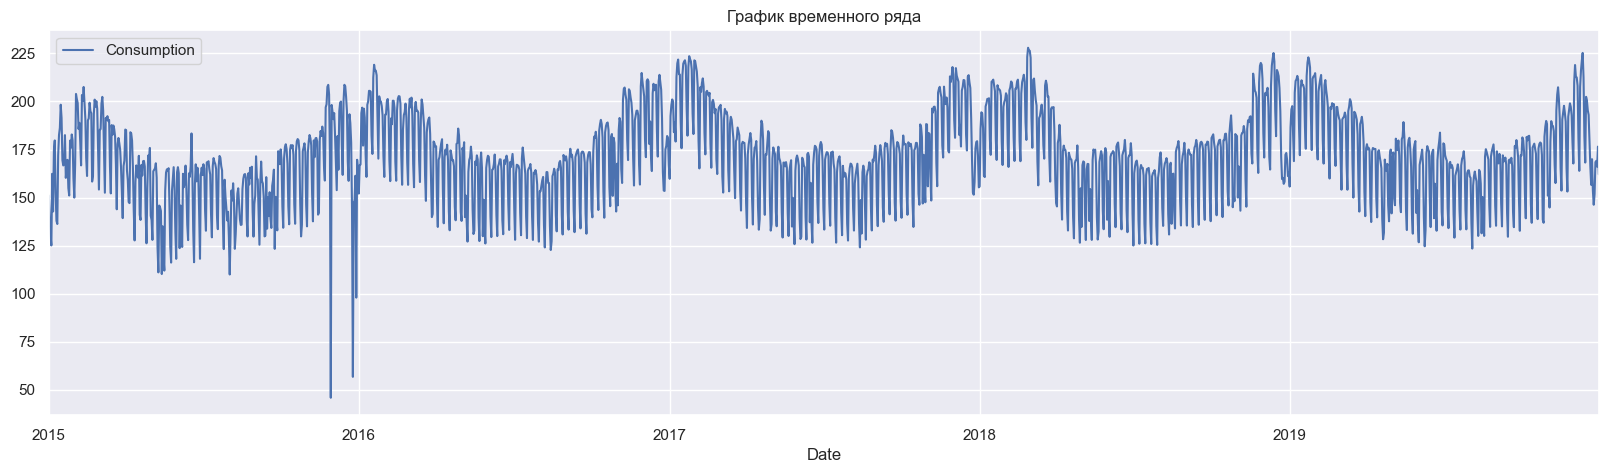

In [10]:
df.plot(
    figsize=(20, 5),
    title='График временного ряда',
    grid = True);


Размер набора данных

In [11]:
print(df.shape)

(1826, 1)


Информация о колонках в наборе

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2015-01-01 to 2019-12-31
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Consumption  1826 non-null   float64
dtypes: float64(1)
memory usage: 28.5 KB


Описание суммарных статистик данных

In [13]:
df.describe()

Consumption
count  1826.000000
mean    170.986710
std      23.504906
min      45.913000
25%     156.702500
50%     171.340500
75%     185.361000
max     227.934000

типы данных

In [14]:
df.dtypes

Consumption    float64
dtype: object

In [15]:
print(f"Минимальная дата: {df.index.min().strftime('%Y-%m-%d')}\nМаксимальная дата: {df.index.max().strftime('%Y-%m-%d')}")

date_difference= df.index.max() - df.index.min()
print(f"Количество дней в промежутке: {date_difference.days} дней")

Минимальная дата: 2015-01-01
Максимальная дата: 2019-12-31
Количество дней в промежутке: 1825 дней


In [16]:
print(f"Пропусков в данных: {df.Consumption.isna().sum()}")

Пропусков в данных: 0


In [17]:
# Удаление пропусков на случай, если они есть
df.dropna(inplace=True)

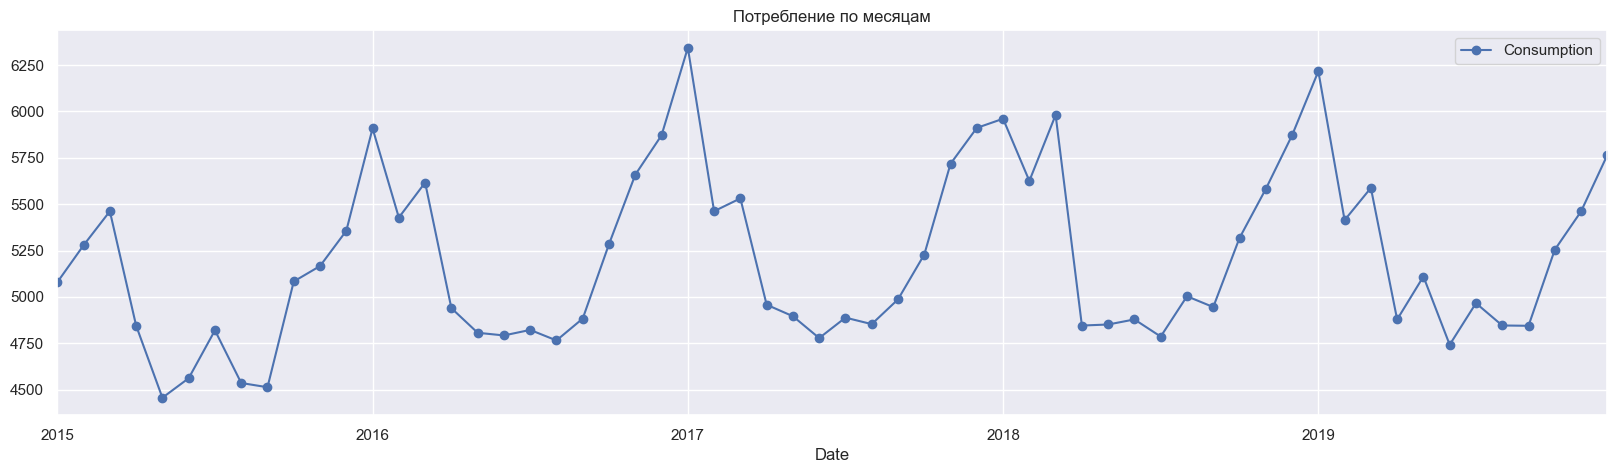

In [18]:
df_monthly = df.resample('M').sum(min_count=4)

df_monthly.plot(
    marker='o',
    title='Потребление по месяцам',
    grid = True);

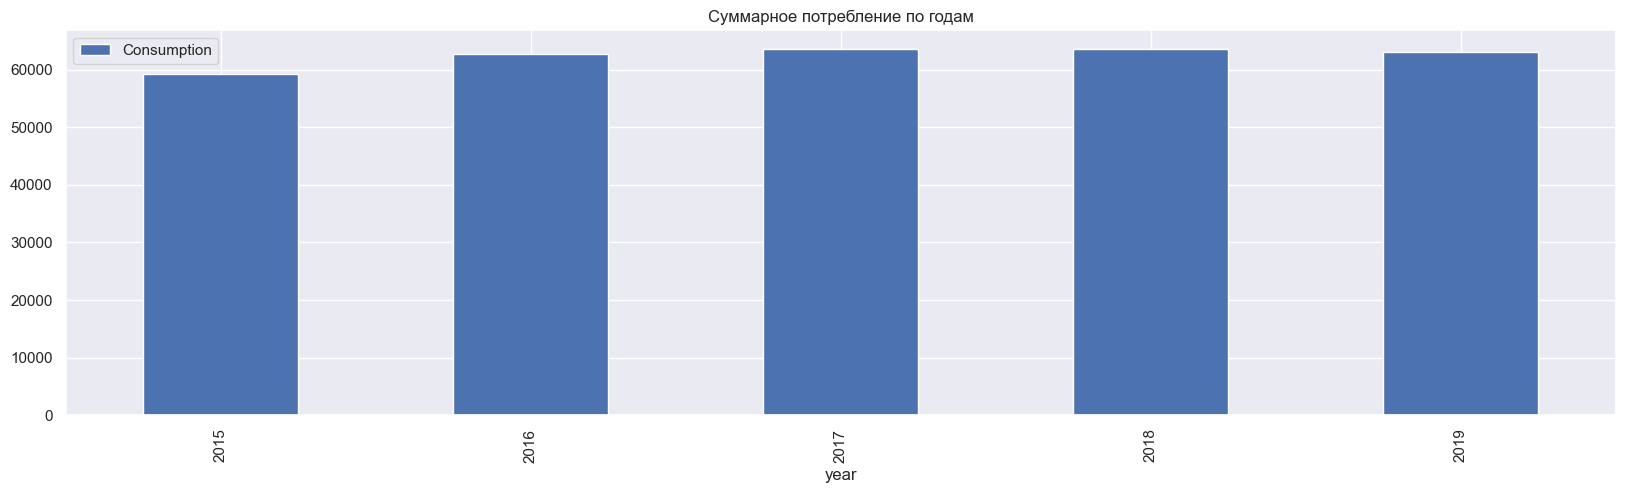

In [19]:
df.groupby(df.index.year).sum().plot(
    kind='bar',
    y='Consumption',
    title='Суммарное потребление по годам',
    grid = True,
    xlabel='year'
);

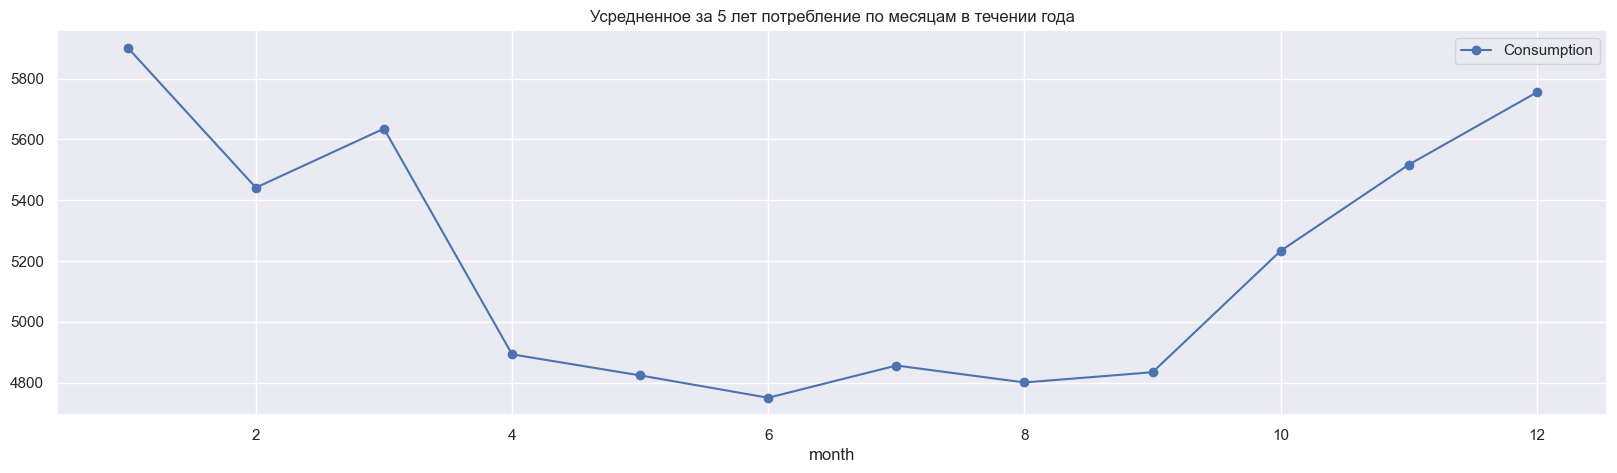

In [20]:
df_monthly.groupby(df_monthly.index.month).mean().plot(
    y='Consumption',
    marker='o',
    title='Усредненное за 5 лет потребление по месяцам в течении года',
    grid = True,
    xlabel='month'
);

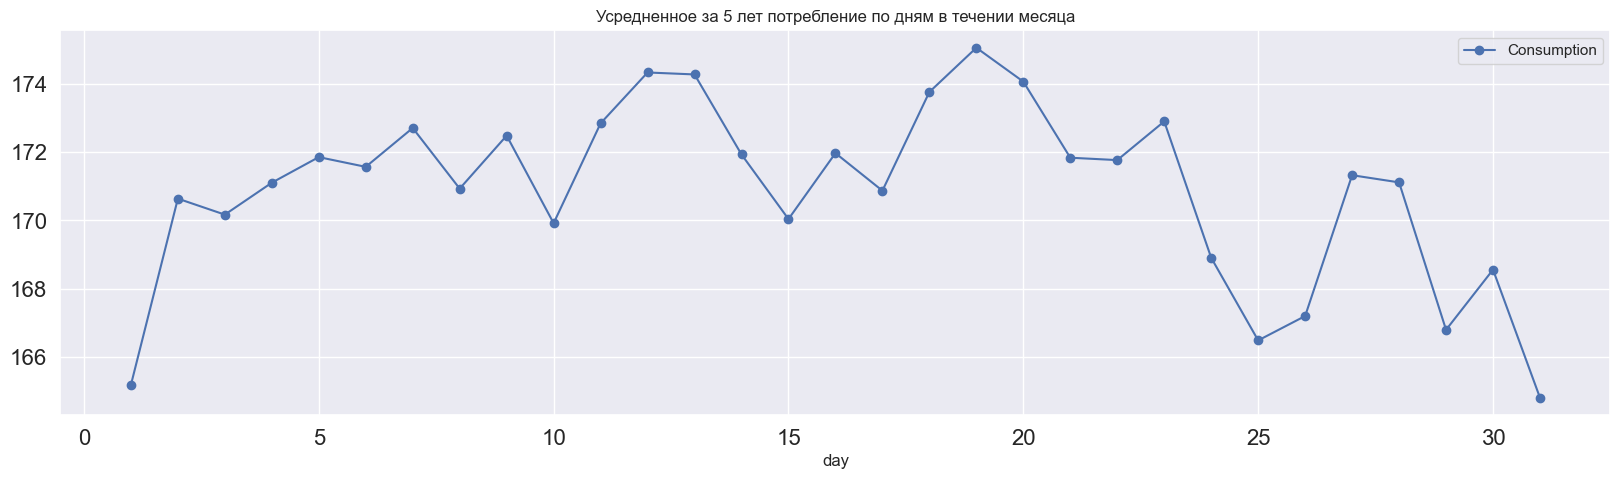

In [21]:
df.groupby(df.index.day).mean().plot(
    y='Consumption',
    marker='o',
    title='Усредненное за 5 лет потребление по дням в течении месяца',
    grid = True,fontsize=16,
    xlabel='day'
);

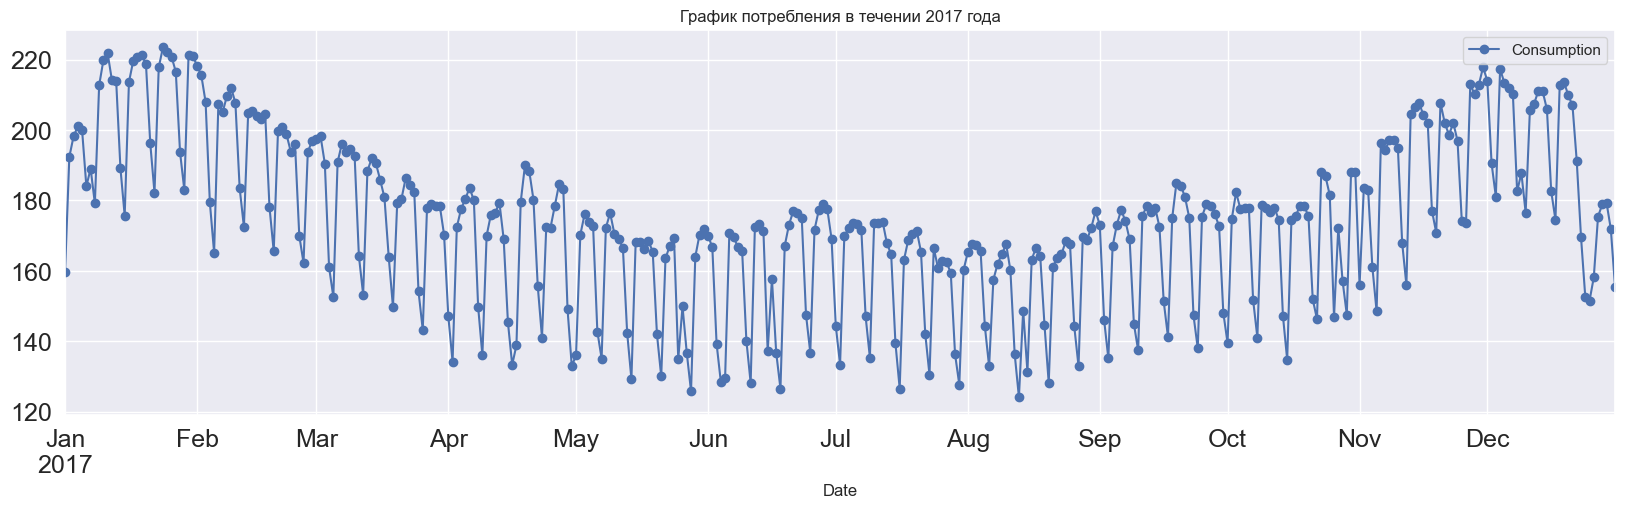

In [22]:
df.loc['2017-01-01':'2017-12-31'].plot(
    figsize=(20, 5),
    marker='o',fontsize=18,
    title='График потребления в течении 2017 года',
    grid = True);

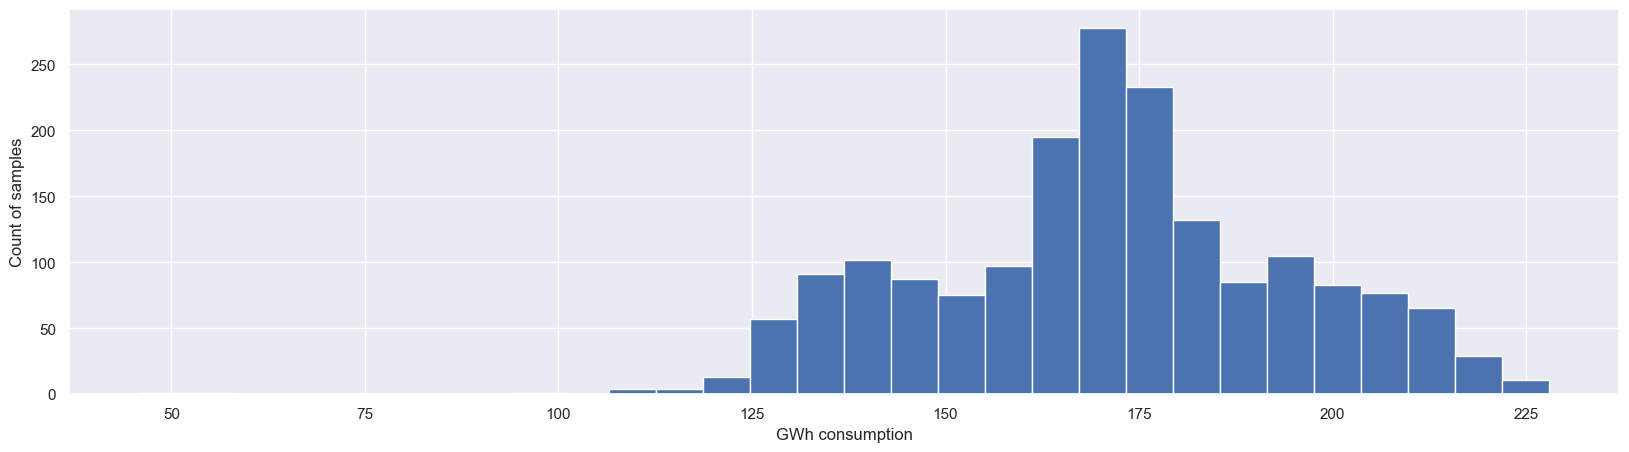

In [23]:
ax = df.Consumption.hist(bins=30)
# ax = df.Consumption.plot(kind='kde' )
ax.set_ylabel('Count of samples')
ax.set_xlabel('GWh consumption')
plt.show()

Предварительные выводы:
- Общее потребление с годами растет, т.е. имеется растущий тренд.
- Имеется общая закономерность изменения потребления в течение года. Зимой потребление всегда увеличивается, летом всегда уменьшается. Имеется провал в феврале, связанный, видимо, с меньшей длительностью месяца.
- Имеется явно выраженная сезонность.
- Потребление энергии имеет 2 явные сезонные составляющие:
  - основная, связанная с изменением потребления в течении года;
  - дополнительная, которая предположительно связана с изменением потребления в течение
   недели.
- Потребление по дням в течении месяца имеет небольшую дисперсию.
- Имеются аномалии и выбросы в виде рекордно низкого потребления в холодное время года, связанные, видимо, с какими-то нарушениями в поставке электроэнергии потребителю,
например, вследствие аварии. Возможно также влияние климата, но столь значительное изменение количества потребляемой энергии вряд ли может быть результатом резкого потепления.

График дневного потребления для периода в 2 месяца, включая начала и конец года

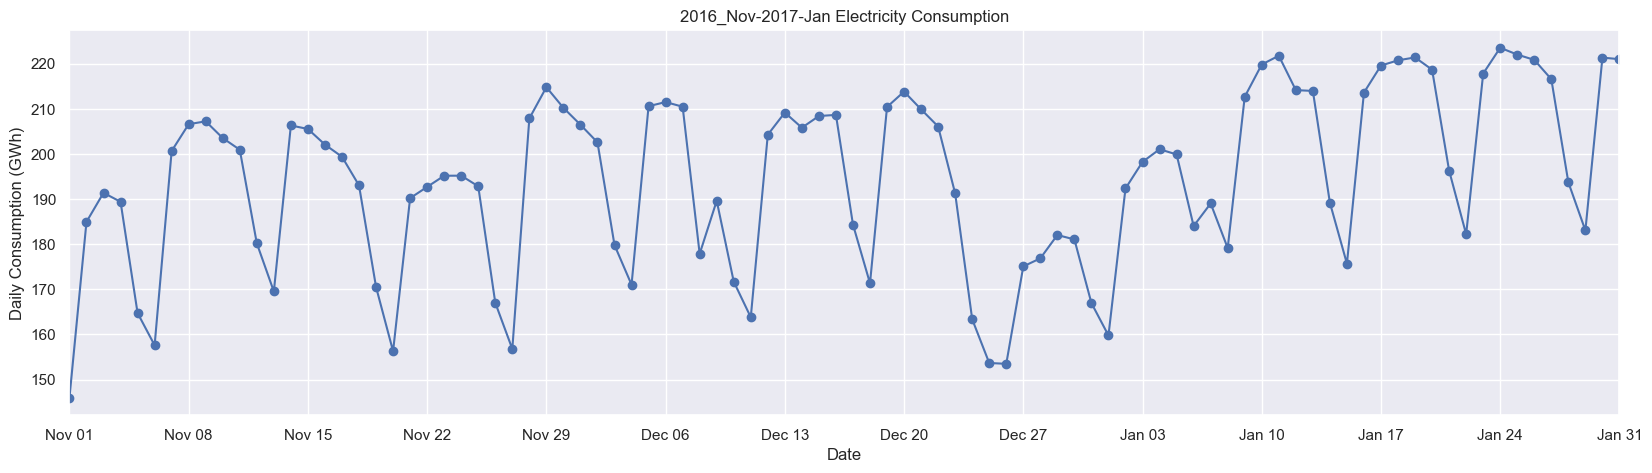

In [24]:
ax = df.loc['2016-11':'2017-01', 'Consumption'].plot(marker='o', linestyle='-')
ax.set_ylabel('Daily Consumption (GWh)')
ax.set_title('2016_Nov-2017-Jan Electricity Consumption')

# For more convinient ticks (week ticks)
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
# Format 3-letter month name and day number
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.show()

У нас имеется две сезонных компоненты.  Спад потребления видимо связан с выходными.  Рассмотрим скользящее среднее.

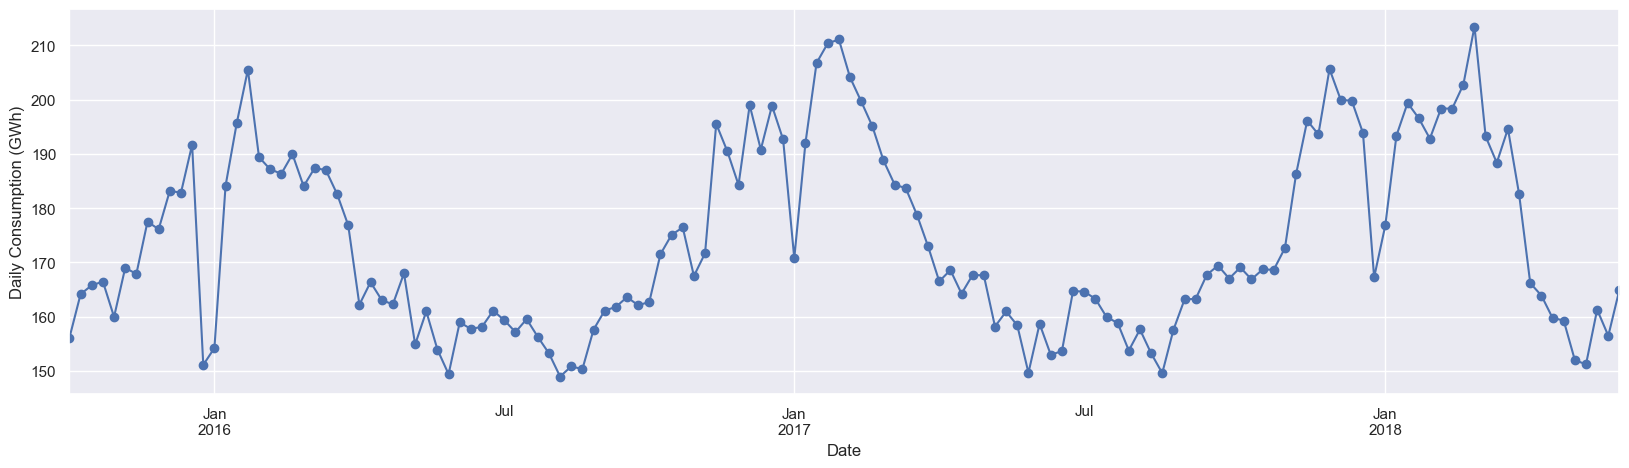

In [25]:
ax = df.loc['2015-10':'2018-05', 'Consumption'].\
    resample('W').mean().plot(marker='o', linestyle='-',linewidth=1.5)
ax.set_ylabel('Daily Consumption (GWh)')
plt.show()

Проверим наличие тренда. Для этого используем скользящее вреднее при помощи метода `rolling`. Также проверим тренд при помощи построения BBox

<Axes: xlabel='Date'>

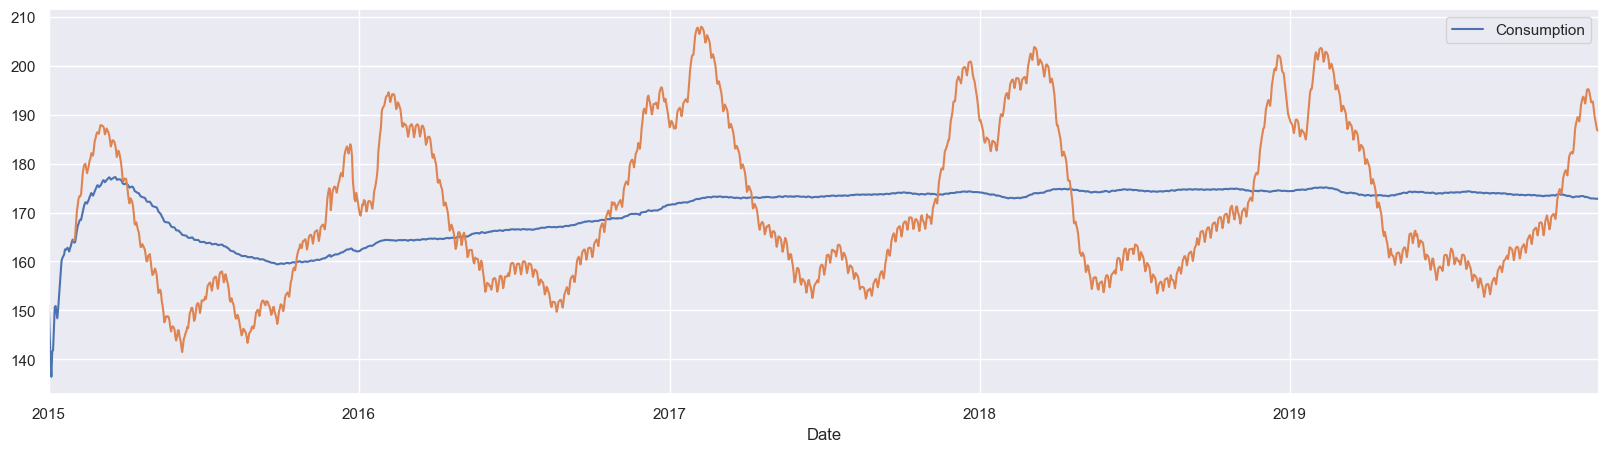

In [26]:
df.rolling('365d').mean().plot( linewidth=1.5, );
df['Consumption'].rolling(30).mean().plot()

В ряде наблюдаются сезонность, небольшой шум и небольшой тренд.

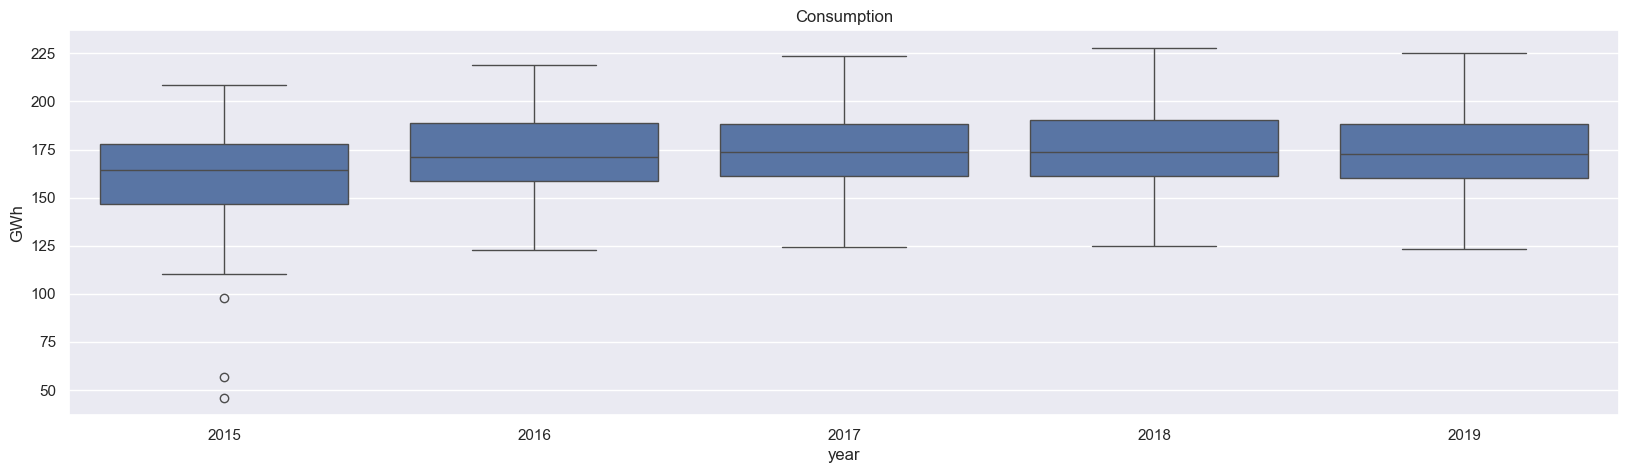

In [27]:
ax = sns.boxplot(data=df, x=df.index.year, y='Consumption')
ax.set_ylabel('GWh')
ax.set_xlabel('year')
ax.set_title('Consumption')
plt.show()

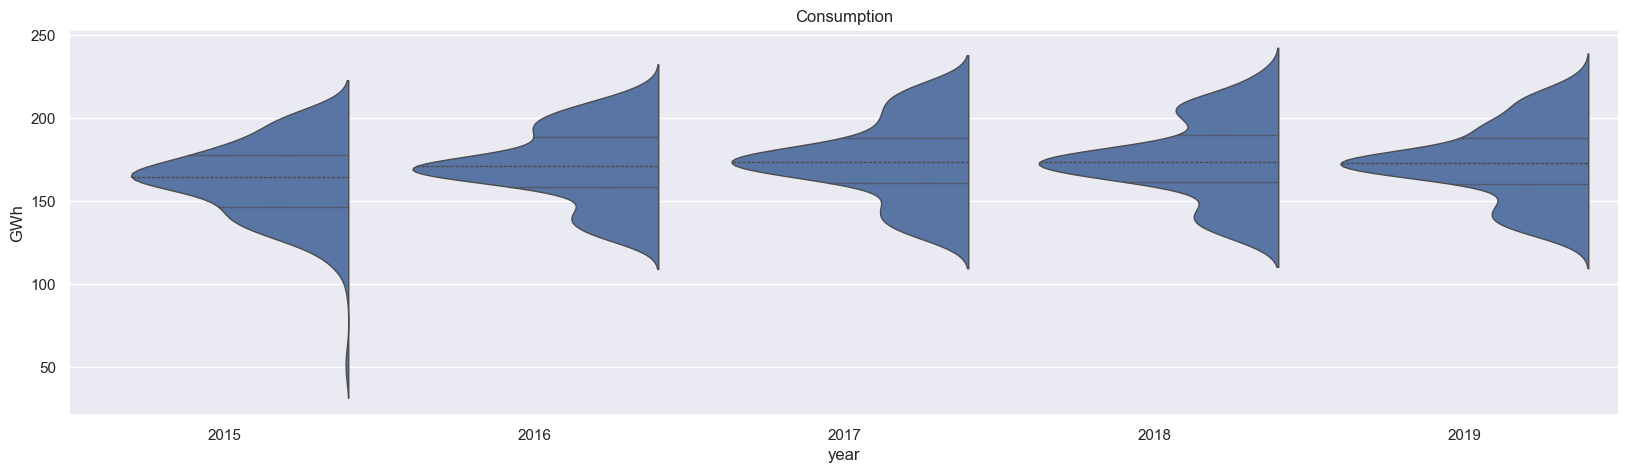

In [28]:
ax=sns.violinplot(data=df, x=df.index.year, y='Consumption',
               split=True, inner="quart", linewidth=1, )
ax.set_ylabel('GWh')
ax.set_xlabel('year')
ax.set_title('Consumption')
plt.show()

Анализ этих графиков подтверждает наличие немного возрастающего тренда, а также аномалий в 2015 г.

Проверим наличие сезонных составляющих

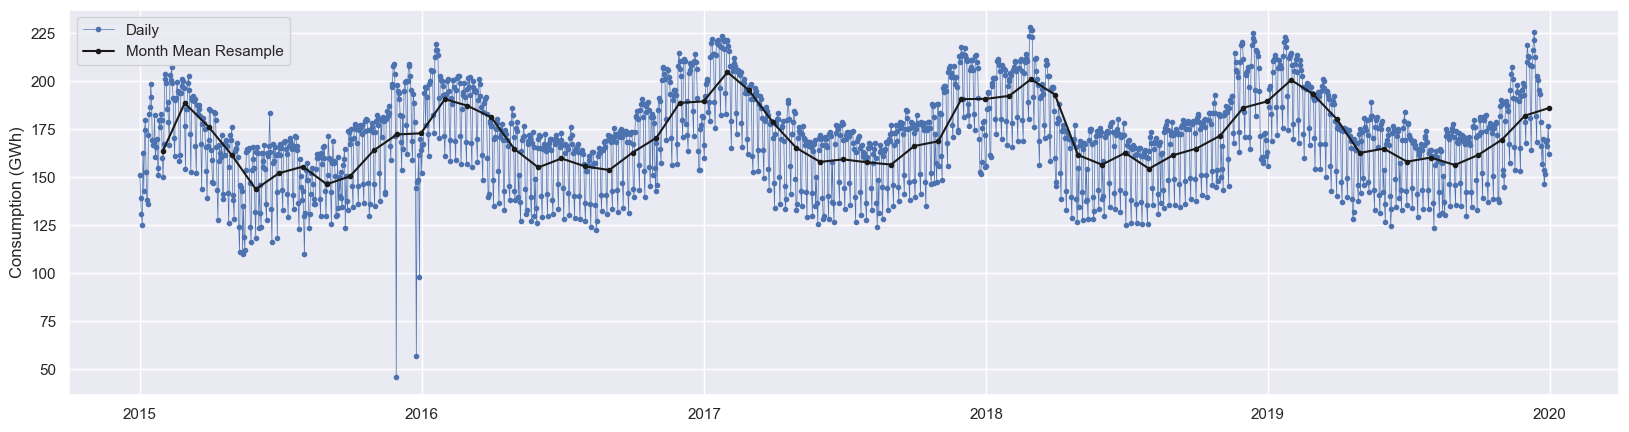

In [29]:
start, end = '2015-01', '2019-12'

fig = plt.figure( figsize=(20, 5),)
plt.plot(df.loc[start:end, 'Consumption'],marker='.', linestyle='-', linewidth=0.5, label='Daily')
plt.plot(df.resample('M').mean().loc[start:end, 'Consumption'], marker='o', markersize=3, linestyle='-', label='Month Mean Resample', color='k')
plt.ylabel('Consumption (GWh)')
plt.legend();

Сезонность явно прослеживается. Аномалии периодически и нерегулярно имеют место быть и вследствие своей единичности больше похоже на выбросы.

Проверим сезонность по месяцам

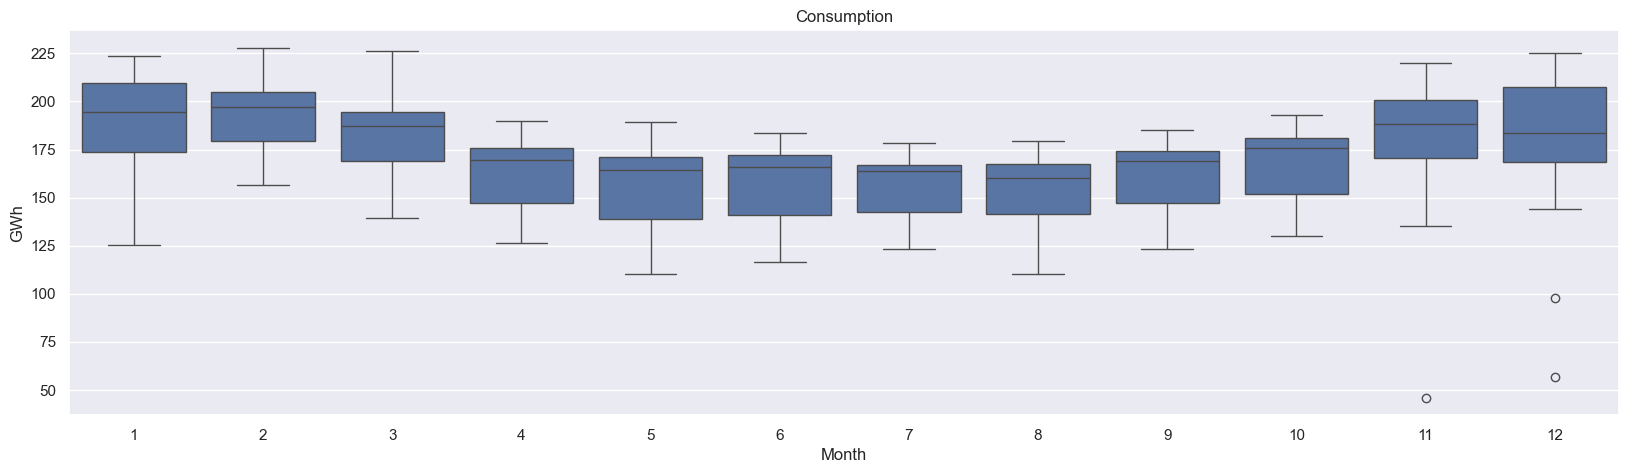

In [30]:
ax = sns.boxplot(data=df, x=df.index.month, y='Consumption')
ax.set_ylabel('GWh')
ax.set_xlabel('Month')
ax.set_title('Consumption')
plt.show()

На boxplot видно небольшое количество выбросов и изменение среднего значения и дисперсии. Можно сделать вывод, что сезонность нестабильна и нестационарна.

Проверим нестационарность сезонности с использованием скользящего среднего по годам

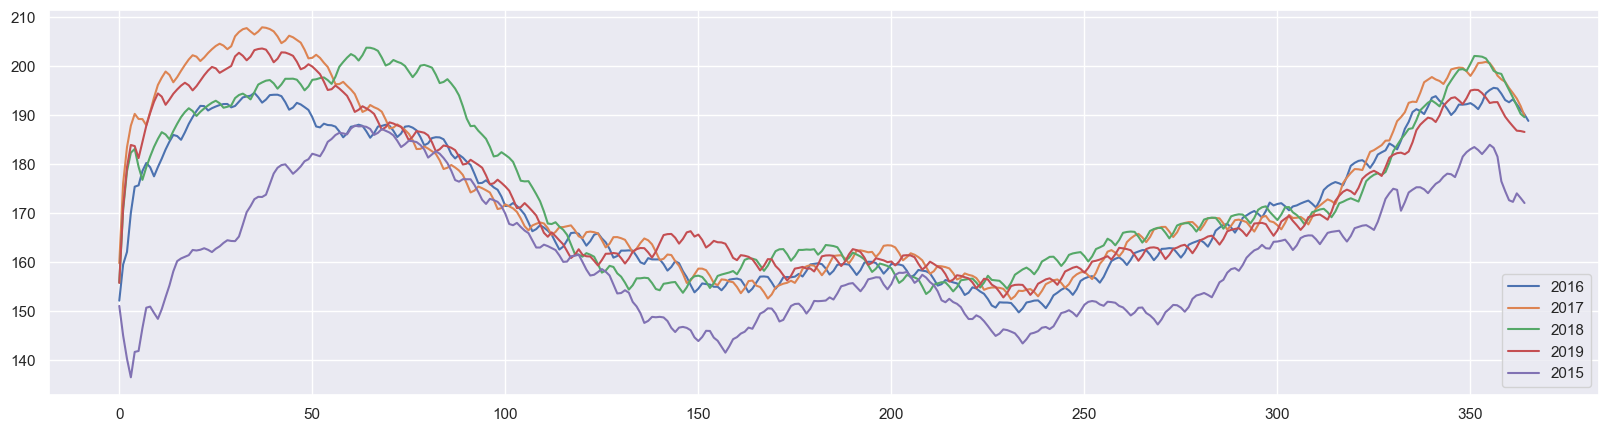

In [31]:
for year in list(set(df.index.year)):
    plt.plot(df.loc[str(year):str(year), 'Consumption'].rolling('30d').mean().values, label=year)
plt.legend()

Вероятно, нестационарность сезонности немого увеличивается от года к году.   Также оценим сезонность дней недели.

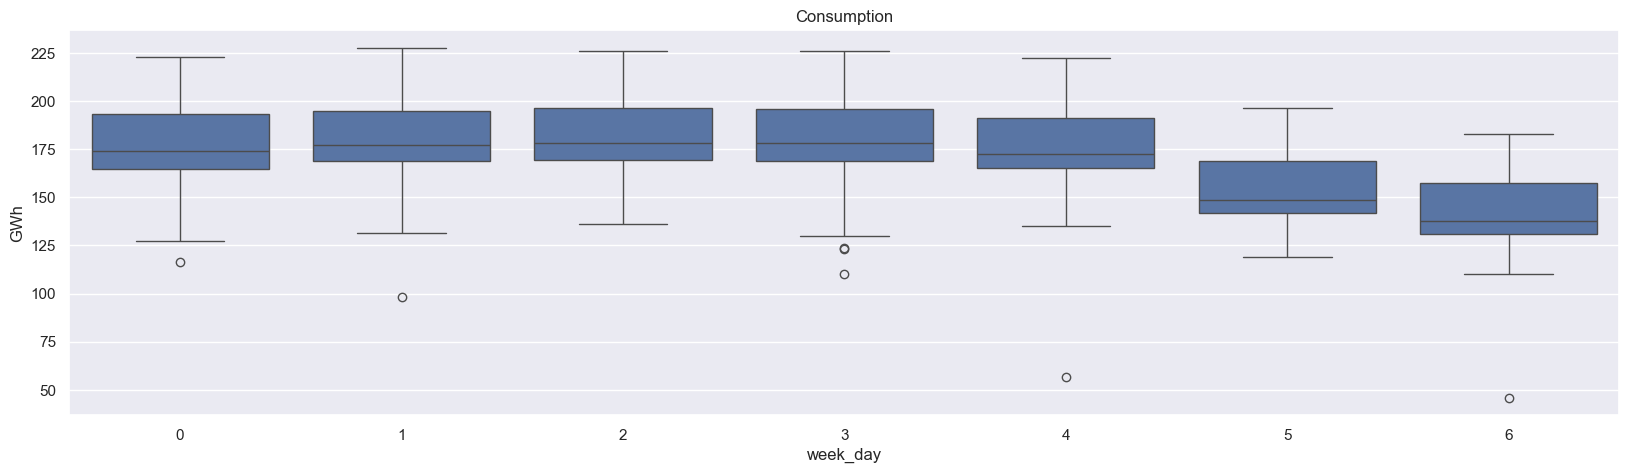

In [32]:
ax = sns.boxplot(data=df, x=df.index.weekday, y='Consumption');
ax.set_ylabel('GWh')
ax.set_xlabel('week_day')
ax.set_title('Consumption')
plt.show()

На графике видна явная сезонность дней недели, а число выбросов небольшое.

Визуализируем тренд, сезонность и шум в общем потреблении электроэнергии:

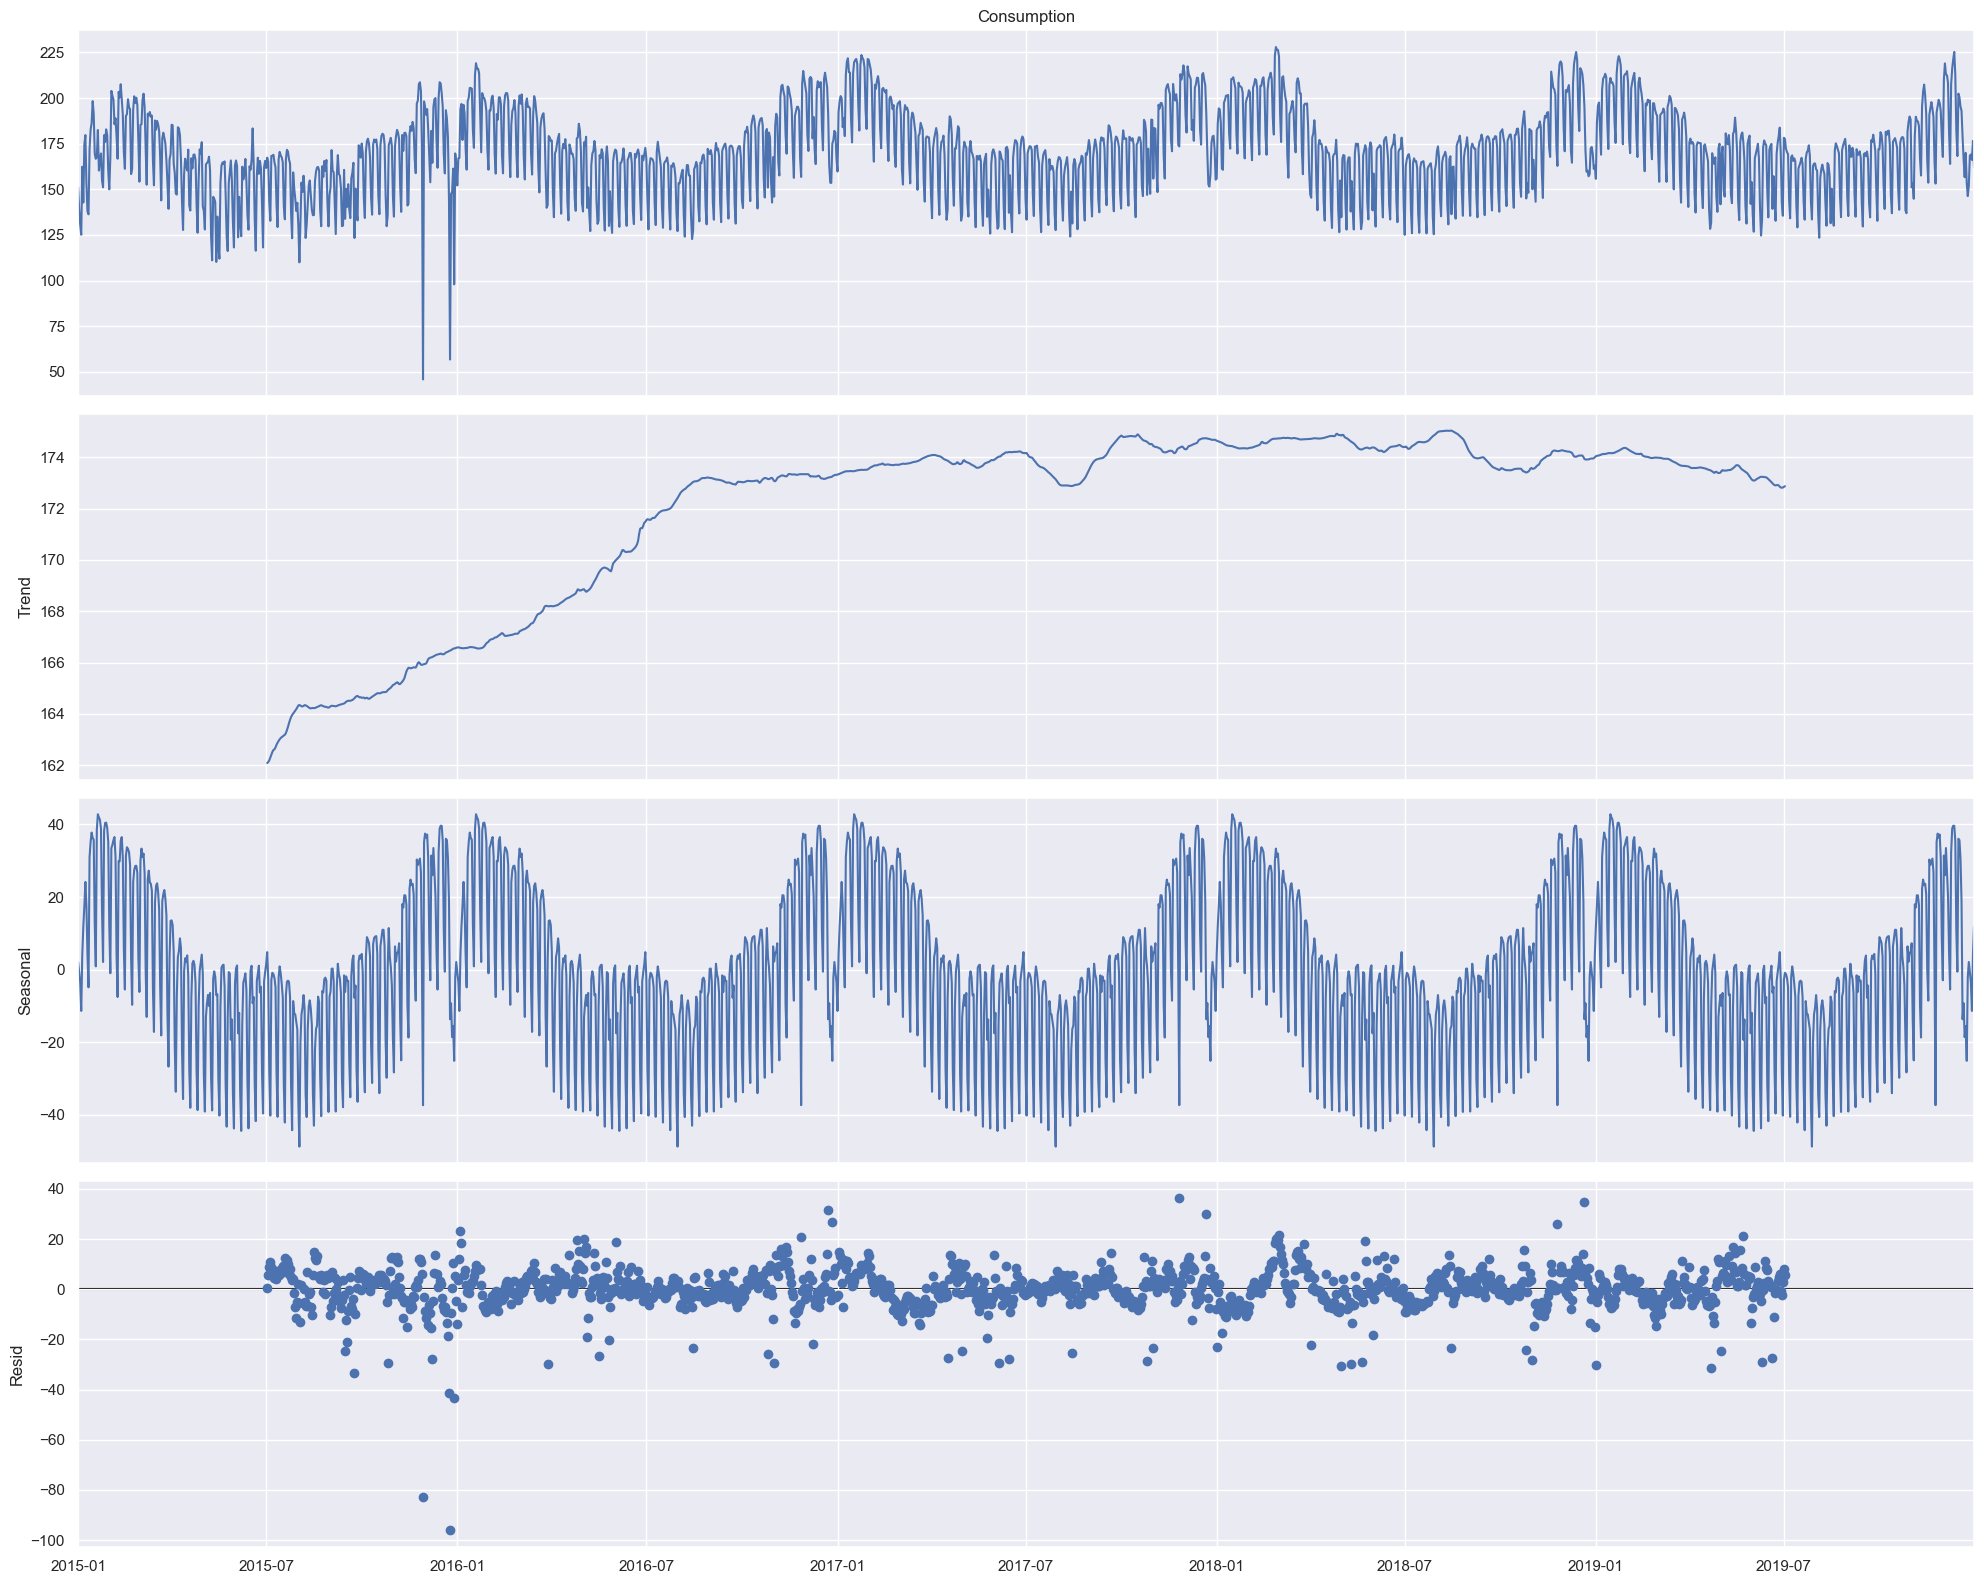

In [33]:
rcParams['figure.figsize'] = 20, 16
decomposition = seasonal_decompose(df['Consumption'], model='additive', period = 364)
fig = decomposition.plot()
plt.show()

Сезонная составляющая:

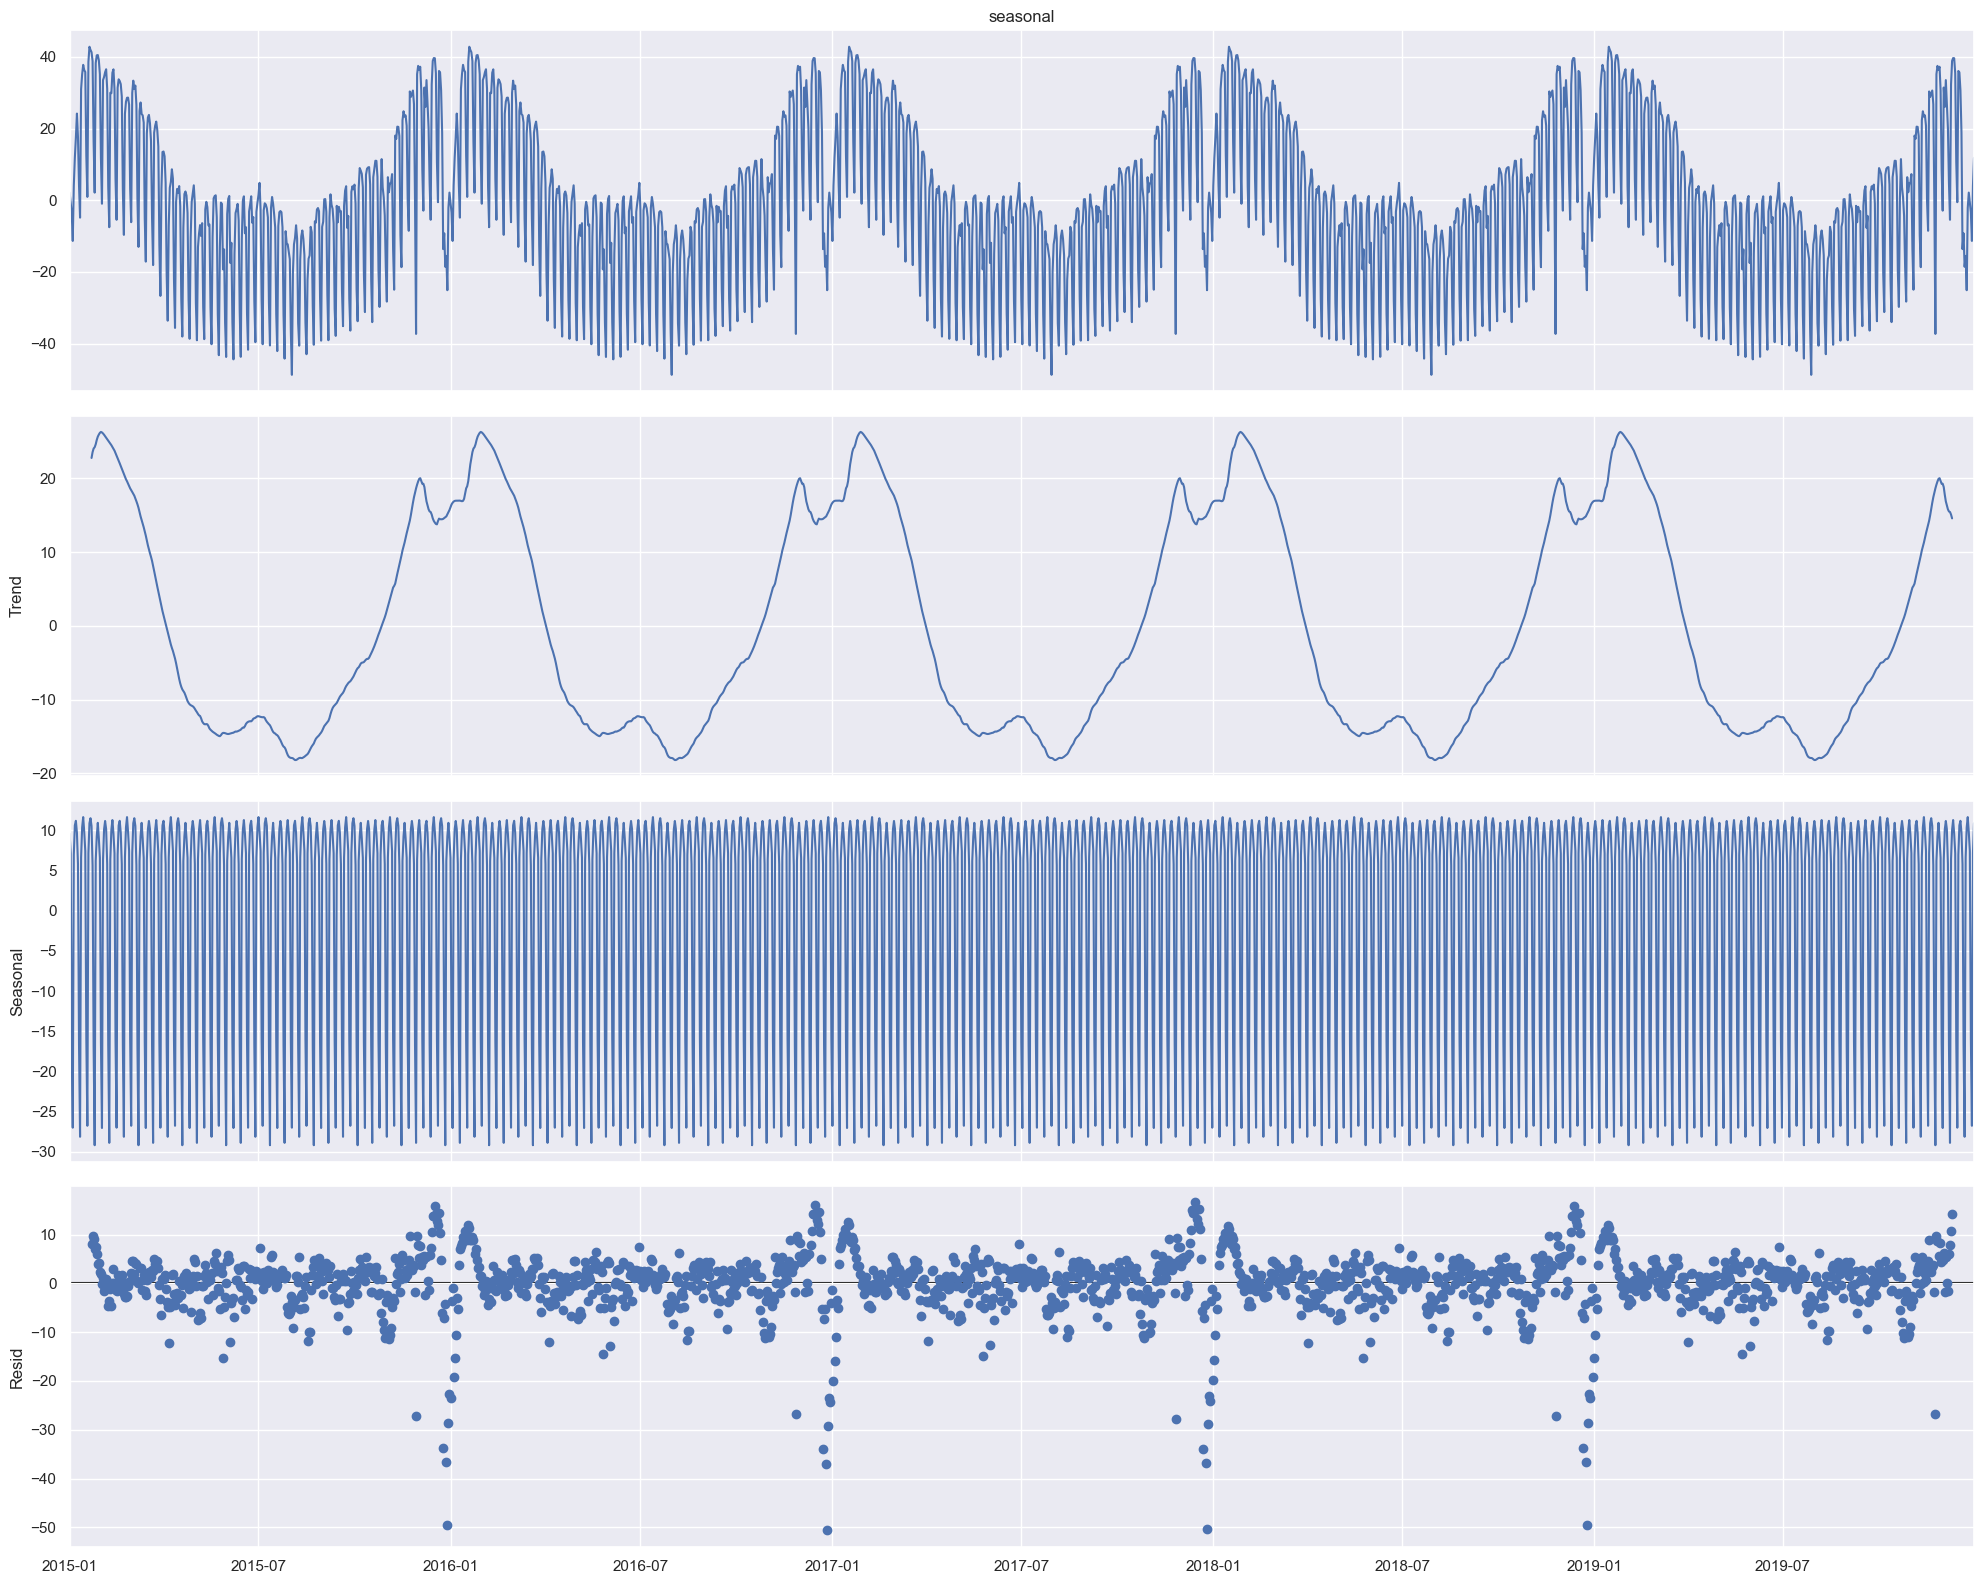

In [34]:
decomposition2 = seasonal_decompose(decomposition.seasonal, model='additive', period = 42)
rcParams['figure.figsize'] = 20, 16
decomposition2.plot()
plt.show()

Сезонная составляющая крупным планом:

<Axes: xlabel='Date'>

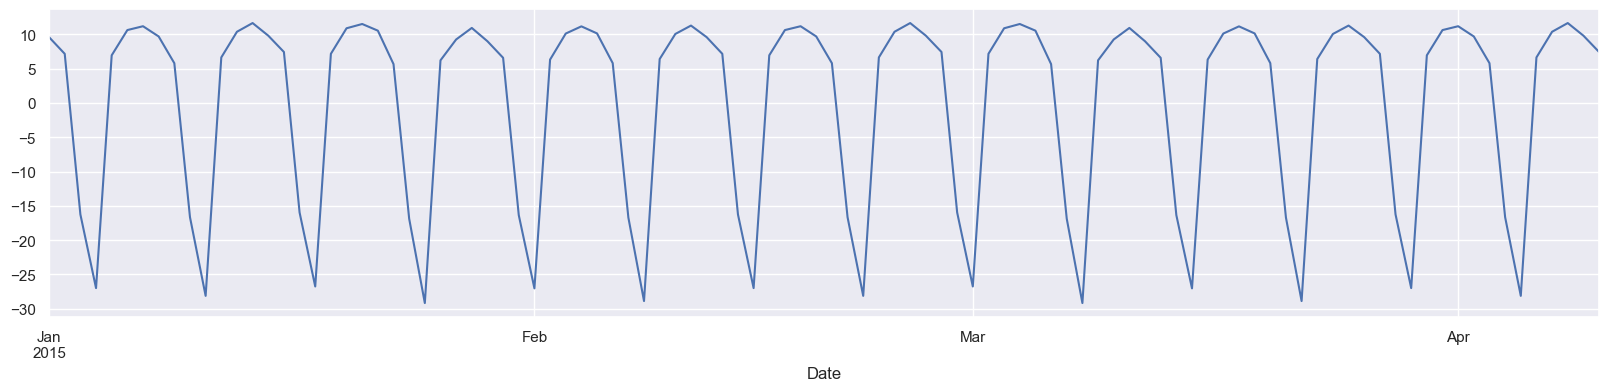

In [35]:
rcParams['figure.figsize'] = 20, 4
decomposition2.seasonal[0:100].plot()

В датасете имеются шумы и выбросы. Тренд (на первом графике) монотонно возрастает с насыщением. Анализ второго тренда (или первой
сезонной компоненты) показывает наличие третьей составляющей сезонности. Выделенная вторая сезонная компонента почти
стационарна, имеется небольшая модуляция по величине.
В целом сезонная компонента  имеет минимум 2 составляющих, одна - с периодом в год, другая - с периодом в неделю.
Анализ третьей компоненты не проводился.


Построим график ACF

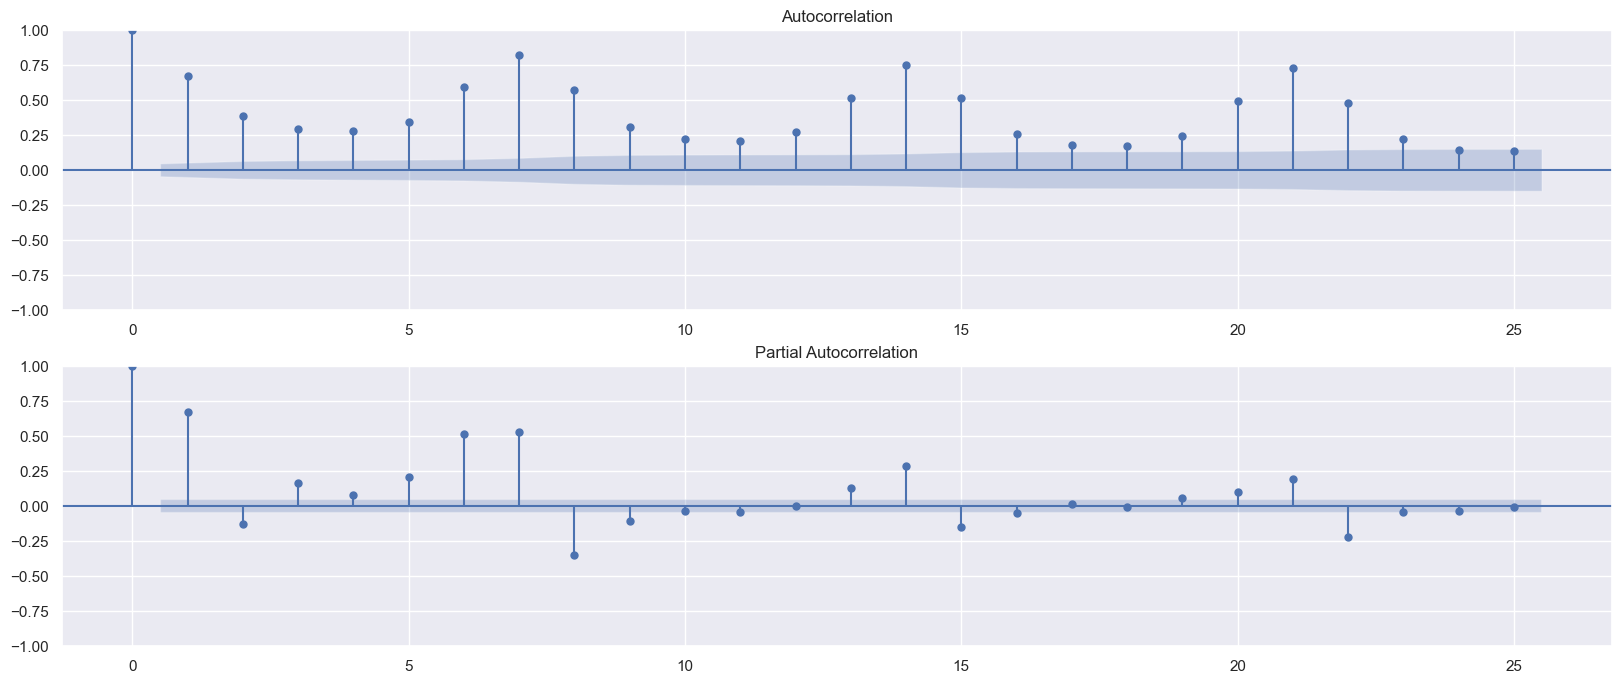

In [36]:
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df['Consumption'], lags=25, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df['Consumption'], lags=25, ax=ax2)

В анализируемом датасете лаги 1, 7, 14, 21 достаточно сильно коррелируют с исходным рядом. Синяя граница показывает
статистическую значимость корреляции. Все лаги меньше 23 выходят за ее пределы, то есть автокорреляция достаточно сильна и ее можно использовать при построении модели. Также такая автокорреляция позволяет предположить наличие сезонных (ежегодных)  колебаний. То, что корреляция постоянно положительная говорит о наличии тренда.

Проверим ряд на стационарность
В качестве теста временного ряда на стационарность используем расширенный тест Дики — Фуллера. В тесте формулируется две гипотезы:
- нулевая гипотеза (H0): временной ряд нестационарный, то есть имеет некоторый тренд и сезонную компоненту;
- альтернативная гипотеза (H1): временной ряд стационарный, то есть не имеет тренда и сезонной компоненты, и данные скорее случайны.

In [37]:
check_ADF(df);

ADF Statistic: -3.5191
p-value: 0.0075
Critical Values:
	1%: -3.4340, 
	5%: -2.8631, 
	10%: -2.5676, 
Вывод: ряд нестационарен


# 6. Предсказания значений ВР

Ранее было установлено, что ряд имеет как минимум 2 составляющие (быструю, с периодом неделя и медленную с периодом 1 год). Для упрощения анализа и без значительных потерь значимости удалим быструю составляющую при помощи перегруппировки данных.

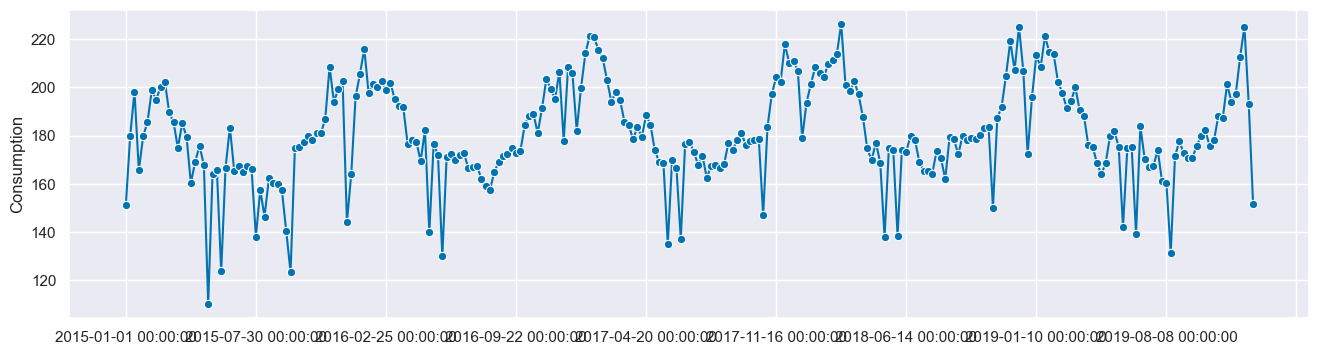

In [38]:
dfy = df.Consumption.asfreq('7d')
sktime.utils.plotting.plot_series(dfy);

Для разделения данных воспользуемся функцией `temporal_train_test_split`, которая позволяет адаптировать разделение данных не разрушая временные зависимости в данных.

Check splitted data size: Train: 144, Test: 117


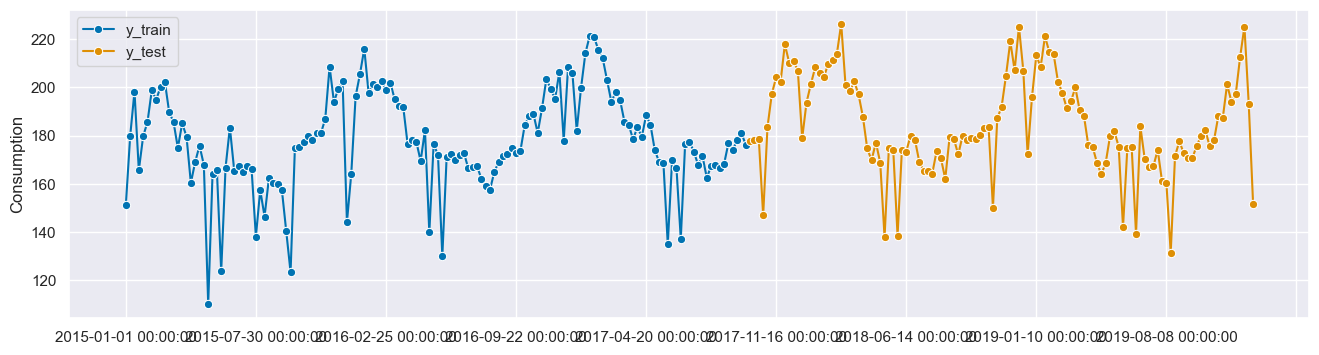

In [39]:
TEST_SIZE = int(0.45*dfy.size)

y_train, y_test = temporal_train_test_split(dfy, test_size=TEST_SIZE)

print(f'Check splitted data size: Train: {y_train.shape[0]}, Test: {y_test.shape[0]}')

sktime.utils.plotting.plot_series(y_train, y_test, labels=["y_train", "y_test"]);

## 6.1. Наивное предсказание (класс NaiveForecaster)

Для этого метода каждое следующее предсказанное значение будет лишь копией предыдущего, начиная с последнего значение тренировочной выборки.
Для проверки ошибки воспользуемся симметричной средней процентной ошибкой (<b>symmetry Mean Average Percentage Error, sMAPE</b>)
    $$ sMAPE =\frac{1}{H}\sum_{i=1}^{H} \frac{|y(h_i) − \hat{y}(h_i)|}{|y(h_i)| + |\hat{y}(h_i)|}
 $$

sMAPE = 0.108


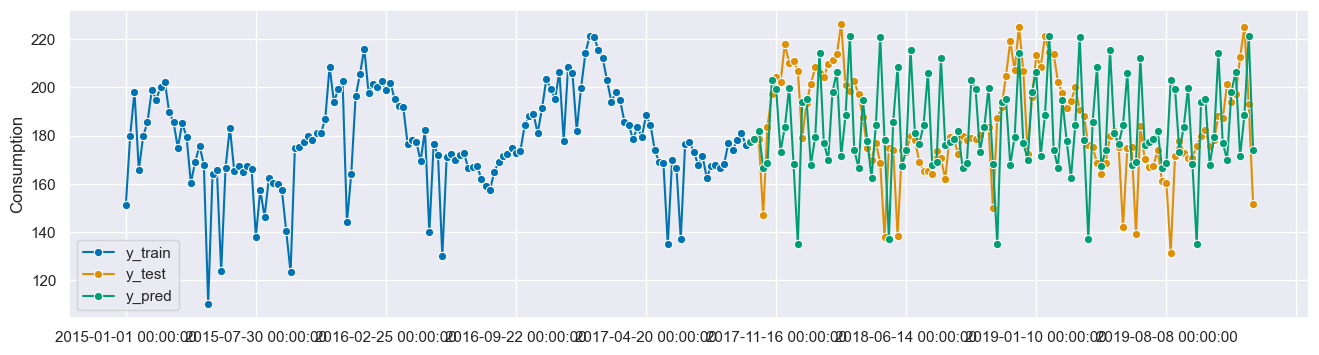

In [40]:
SEASON = 46

# ГОРИЗОНТ
fh = ForecastingHorizon(y_test.index, is_relative=False)

# ПРЕДСКАЗАТЕЛЬ
forecaster = NaiveForecaster(strategy="last", sp=SEASON)
forecaster.fit(y_train)

# ПРЕДСКАЗАНИЕ
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

# ОШИБКА
print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

sMAPE = 0.097


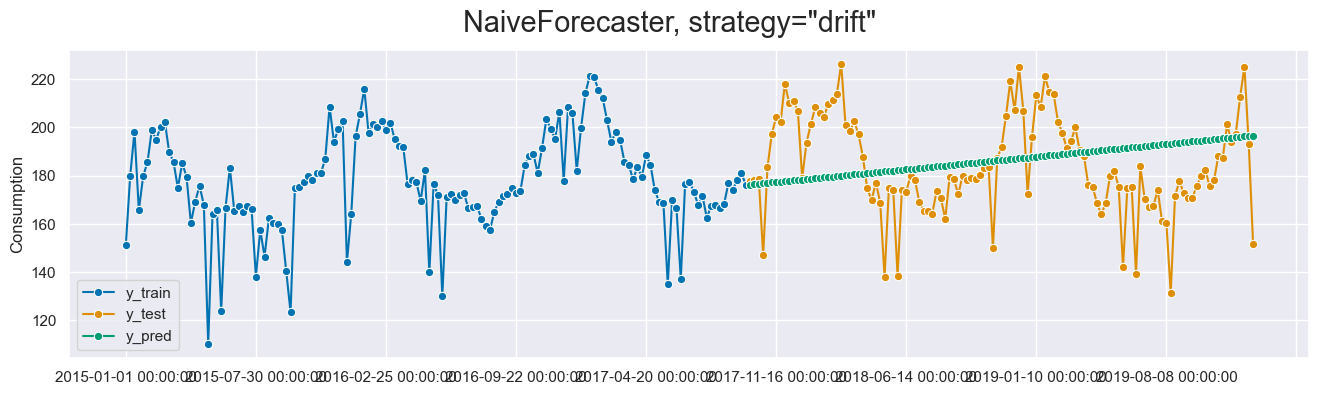

In [41]:
forecaster = NaiveForecaster(strategy="drift")
forecaster.fit(y_train)
y_pred_drift = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred_drift, title = 'NaiveForecaster, strategy="drift"', labels=["y_train", "y_test", "y_pred"])
print(f'sMAPE = {smape(y_pred_drift.values, y_test.values):.3f}')

sMAPE = 0.056


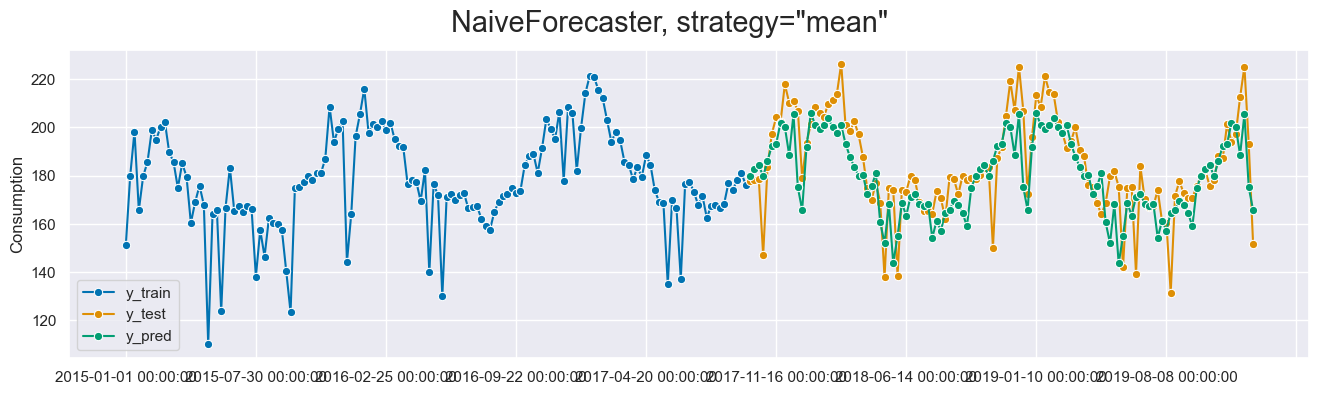

In [42]:
SEASON=52
forecaster = NaiveForecaster(strategy="mean", sp=SEASON)
forecaster.fit(y_train)
y_pred_mean = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred_mean, title = 'NaiveForecaster, strategy="mean"', labels=["y_train", "y_test", "y_pred"])
print(f'sMAPE = {smape(y_pred_mean.values, y_test.values):.3f}')

Лучший результат показало наивное предсказание со стратегией "среднее значение" (mean) и сезонностью 52 - sMAPE= 0.056

## 6.2. Экспоненциональное сглаживание

sMAPE = 0.088


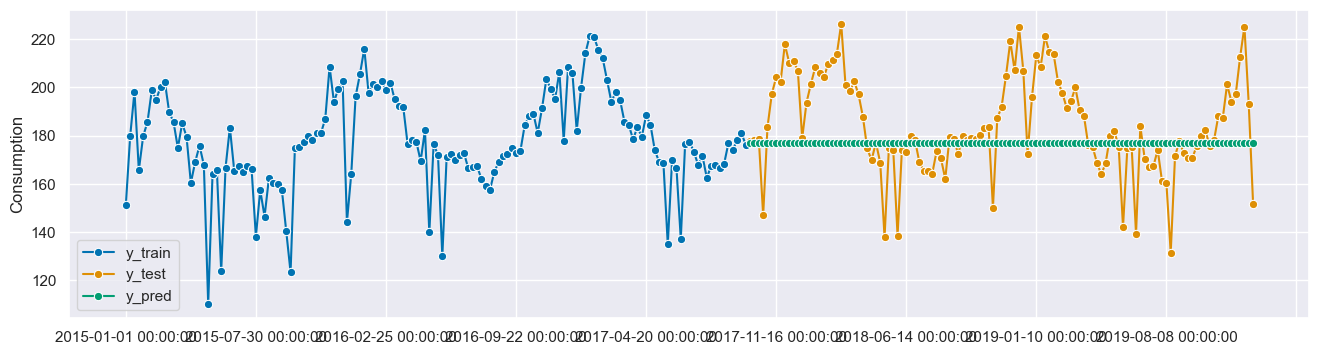

In [43]:
forecaster = ExponentialSmoothing()
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

holt_winter
sMAPE = 0.080
holt_winter_mul_boxcox
sMAPE = 0.070
holt_winter_smul_boxcox
sMAPE = 0.090


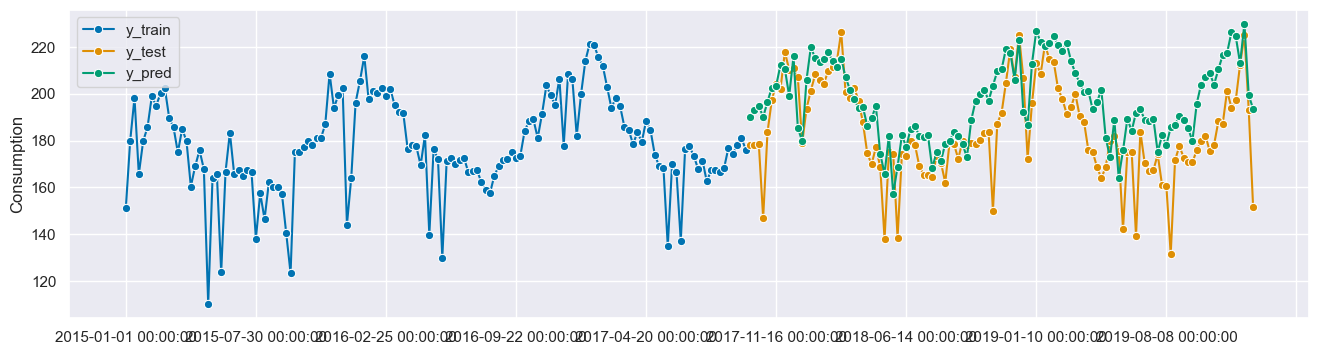

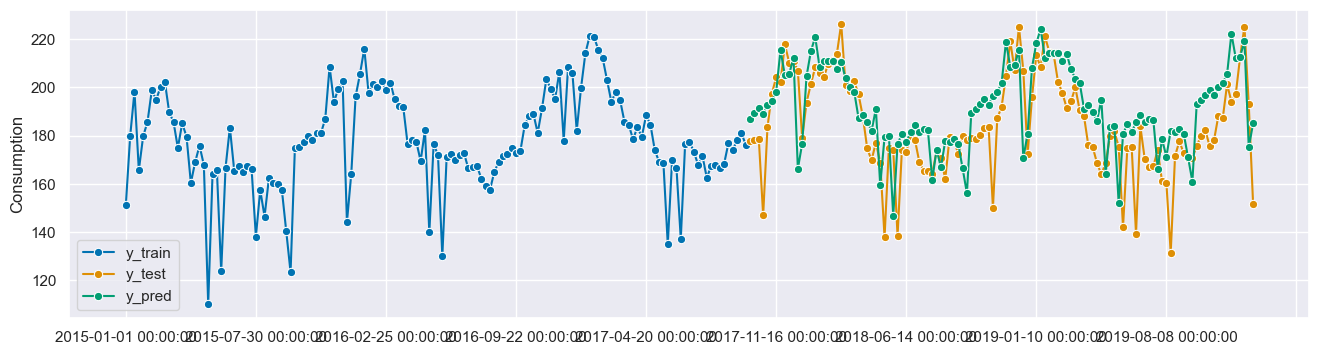

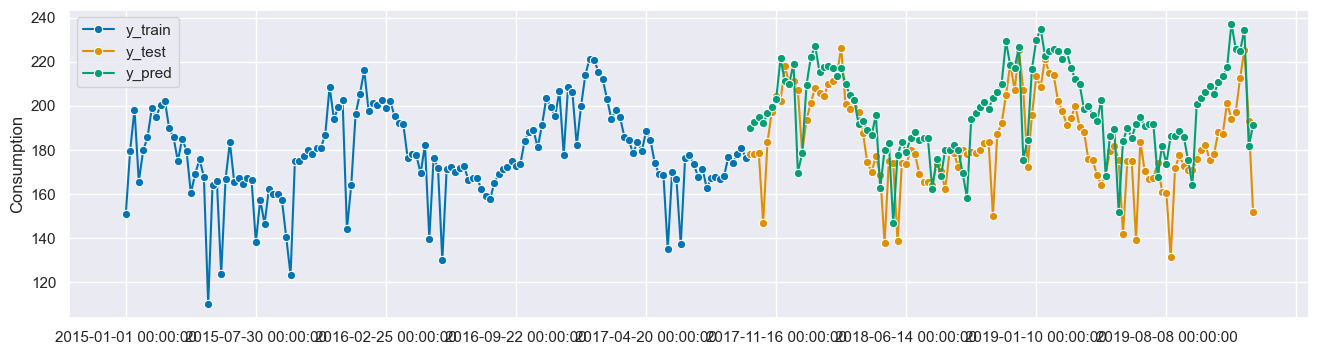

In [44]:
SEASON = 52

# МЕТОДЫ
ses         = ExponentialSmoothing(sp=SEASON)
holt        = ExponentialSmoothing(trend="add", damped_trend=False,  sp=SEASON)
damped_holt = ExponentialSmoothing(trend="add", damped_trend=True,   sp=SEASON)
holt_winter = ExponentialSmoothing(trend="add", seasonal="additive", sp=SEASON)
holt_winter_add_boxcox  = ExponentialSmoothing(trend="add", seasonal="additive", use_boxcox =True, sp=SEASON)
holt_winter_mul_boxcox  = ExponentialSmoothing(trend="mul", seasonal="additive", use_boxcox =True, sp=SEASON)
holt_winter_sadd_boxcox = ExponentialSmoothing(trend="add", seasonal="mul", use_boxcox =True, sp=SEASON)
holt_winter_smul_boxcox = ExponentialSmoothing(trend="mul", seasonal="mul", use_boxcox =True, sp=SEASON)

print('holt_winter')
forecaster1 = holt_winter
forecaster1.fit(y_train)
y_pred = forecaster1.predict(fh)
print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

print('holt_winter_mul_boxcox')
forecaster2 = holt_winter_mul_boxcox
forecaster2.fit(y_train)
y_pred = forecaster2.predict(fh)
print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

print('holt_winter_smul_boxcox')
forecaster3 = holt_winter_smul_boxcox
forecaster3.fit(y_train)
y_pred = forecaster3.predict(fh)
print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

Наилучший результат показала модель модели экспоненциального сглаживания с трендом, сезонностью и преобразованием Бокса-Кокса (trend="multiplicative", seasonal="additive", use_boxcox =True, sp=52), sMAPE = 0.070

### Ансамбль предсказаний экспоненциального сглаживания

sMAPE = 0.063


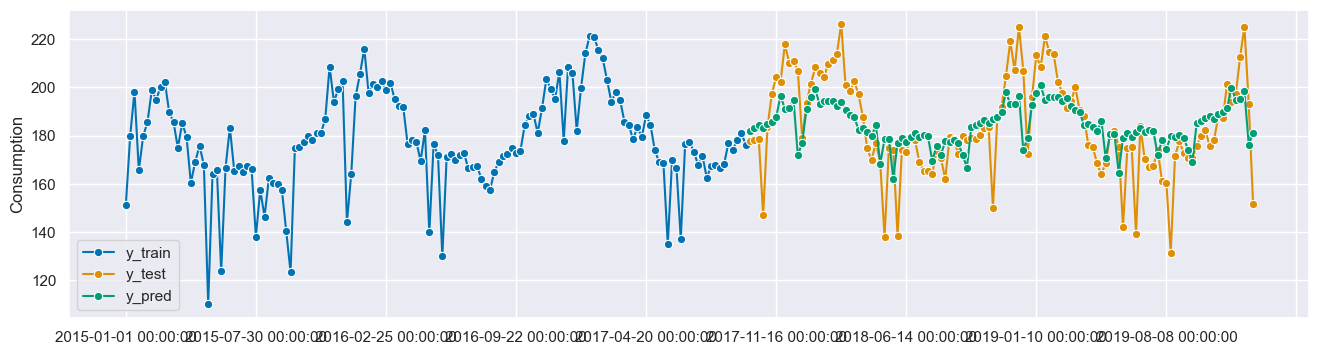

In [45]:
SEASON = 52

# МЕТОДЫ
ses         = ExponentialSmoothing(sp=SEASON)
holt        = ExponentialSmoothing(trend="add", damped_trend=False,  sp=SEASON)
damped_holt = ExponentialSmoothing(trend="add", damped_trend=True,   sp=SEASON)
holt_winter = ExponentialSmoothing(trend="add", seasonal="additive", sp=SEASON)
holt_winter_add_boxcox  = ExponentialSmoothing(trend="add", seasonal="additive", use_boxcox =True, sp=SEASON)
holt_winter_mul_boxcox  = ExponentialSmoothing(trend="mul", seasonal="additive", use_boxcox =True, sp=SEASON)
holt_winter_sadd_boxcox = ExponentialSmoothing(trend="add", seasonal="mul", use_boxcox =True, sp=SEASON)
holt_winter_smul_boxcox = ExponentialSmoothing(trend="mul", seasonal="mul", use_boxcox =True, sp=SEASON)

# ПРЕДСКАЗАТЕЛЬ
forecaster = EnsembleForecaster(
    [
        # ("ses", ses),
#         ("holt", holt),
        ("damped", damped_holt),
#         ("holt-winter",holt_winter),
#         ("holt-winter, additive trend, box-cox", holt_winter_add_boxcox),
        ("holt-winter, multiplicative trend, box-cox", holt_winter_mul_boxcox),
        # ("holt-winter, multiplicative season, box-cox", holt_winter_sadd_boxcox),
        # ("holt-winter, multiplicative both,   box-cox", holt_winter_smul_boxcox)
    ]
)
forecaster.fit(y_train)

# ПРЕДСКАЗАНИЕ
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

# РЕЗУЛЬТАТ
print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

Удалось немного улучшить модель за счет применения дополнительного сглаживания с параметрами: trend="add", damped_trend=True,   sp=52. Показатель уменьшился до sMAPE = 0.063.

### AutoETS

В общем случае пакет `sktime` позволяет использовать автоматизированный подбор параметров модели экспоненциального сглаживания. Для этого может быть использован пакет `AutoETS`. Модель, реализуемая данным пакетом также называется `Error-Trend-Season (ETS)`.

/var/lib/python/python_venvs/torch_streamlit/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/lib/python/python_venvs/torch_streamlit/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/lib/python/python_venvs/torch_streamlit/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/lib/python/python_venvs/torch_streamlit/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood o

sMAPE = 0.076


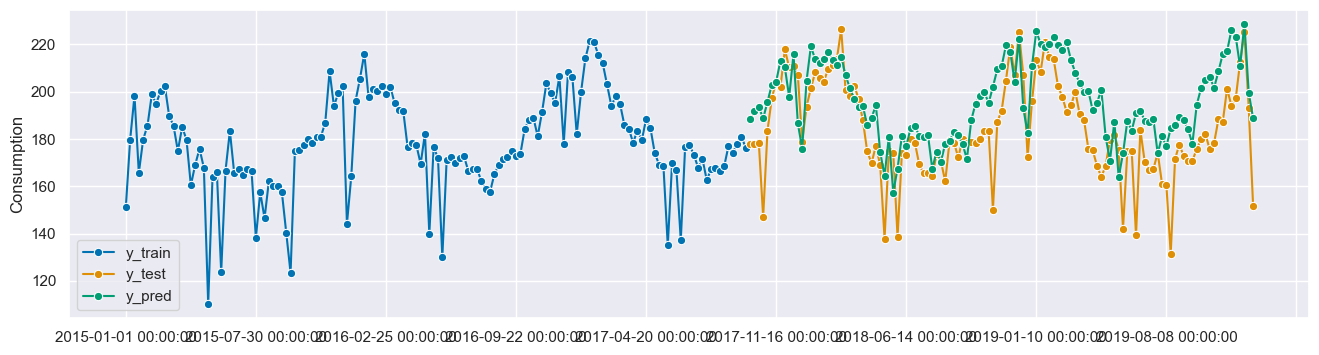

In [49]:
SEASON = 52

forecaster = AutoETS(auto=True, sp=SEASON, n_jobs=-1)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}');

Модель с автоматическим подбором параметров ухудшила предыдущий результат (sMAPE = 0.076)

## 6.3. Регрессия ближайших соседей

sMAPE = 0.061


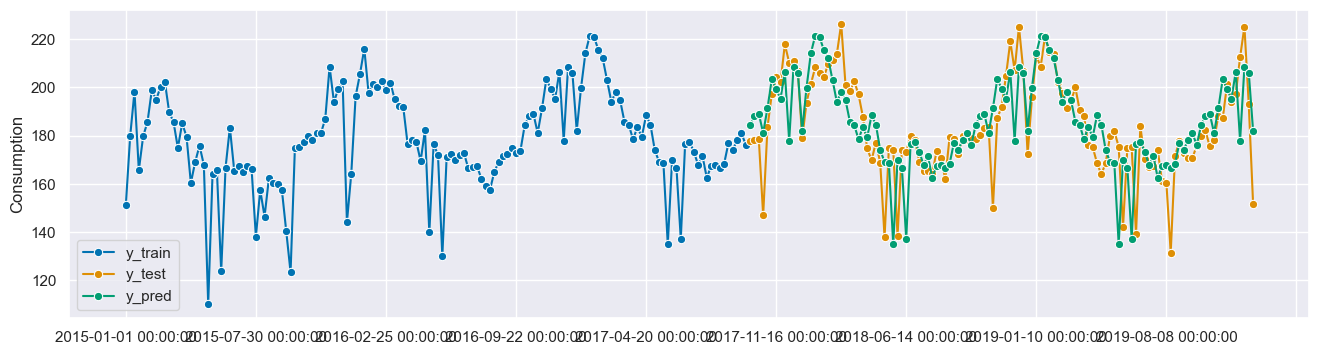

In [50]:
REGRESSION_WINDOW = 15
regressor  = KNeighborsRegressor(n_neighbors=1)
forecaster = make_reduction(regressor, window_length=REGRESSION_WINDOW, strategy="recursive")

forecaster.fit(y_train)

y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

## 6.4. Prophet

Prophet - метод предсказания временных рядов на основе т.н. обобщенной регрессии для модели бизнес процессов, которая включает тренд с точками перегиба и насыщением, несколько компонент сезонности и редкие, но регулярные события (типа выходных дней).

15:16:33 - cmdstanpy - INFO - Chain [1] start processing
15:16:33 - cmdstanpy - INFO - Chain [1] done processing


sMAPE = 0.056


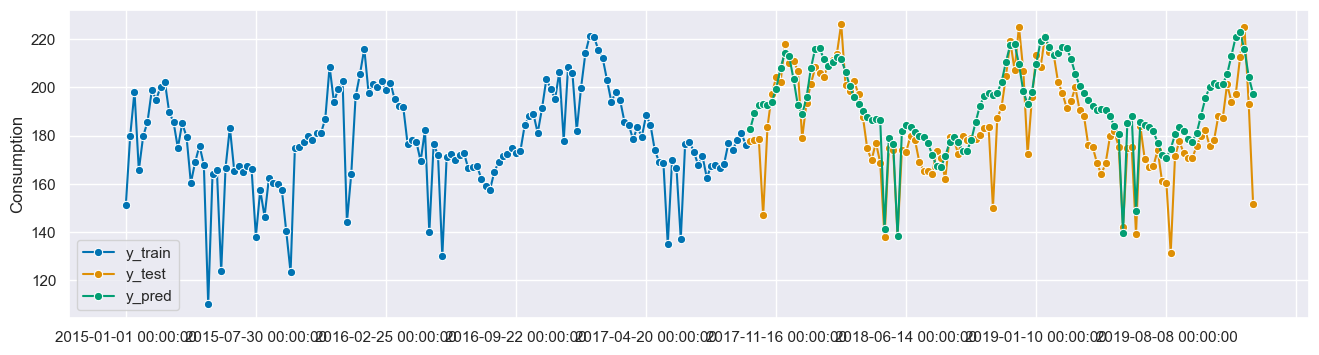

In [51]:
forecaster = Prophet(
                    seasonality_mode='additive',
                    n_changepoints=int(len(y_train) / 3),
                    add_country_holidays={'country_name': 'Austria'},
                    yearly_seasonality=True)

forecaster.fit(y_train)
fh = ForecastingHorizon(y_test.index, is_relative=False)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

Выводы: из всех опробованных методов наилучшим оказался самый простой: наивное предсказание со стратегией "среднее
значение" (mean) и сезонностью 52 - sMAPE= 0.056, с таким же результатом: Prophet и sMAPE = 0.056.

## 6.5. Модель SARIMA

### Анализ стационарности временного ряда

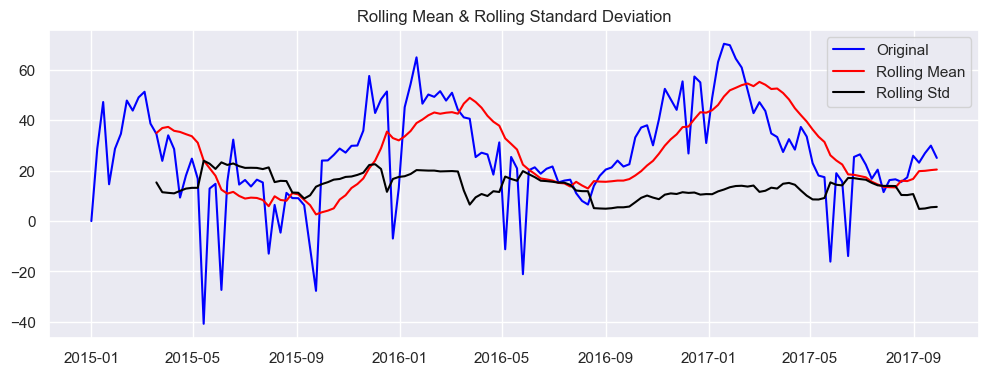

In [52]:
rolling_mean = y_train.rolling(window = 12).mean()
rolling_std  = y_train.rolling(window = 12).std()

plt.figure(figsize=(12,4), dpi=100)

plt.plot(y_train-y_train[0],      color = 'blue',  label = 'Original')
plt.plot(rolling_mean-y_train[0], color = 'red',   label = 'Rolling Mean')
plt.plot(rolling_std,             color = 'black', label = 'Rolling Std')

plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

Ряд нестационарный, в нем видно достаточно сильное влияние сезонной составляющей, поэтому следует перейти к модели
`ARIMA` с сезонными
 эффектами (`Seasonal ARIMA - SARIMA`).  Такая модель обозначается как
$$SARIMA (p, d, q) (P, D, Q) s.$$
Где
* (`p, d, q`) -  несезонные параметры;
* (`P, D, Q`) - сезонные порядки, которые следуют тому же порядку определений как и описанные выше, но применяются к сезонной составляющей временного ряда;
* `s` - это периодичность временного ряда (например, 4 для квартальных периодов, 12 для годовых периодов и т.д.).

In [53]:
check_ADF(y_train);

ADF Statistic: -2.6303
p-value: 0.0869
Critical Values:
	1%: -3.4776, outperformed
	5%: -2.8823, outperformed
	10%: -2.5778, 
Вывод: ряд стационарен


Расширенный тест Дики-Фуллера показал, что ряд является стационарным, что немного противоречит наблюдаемой картине на
 графиках. К тому полученное значение лишь немного превышает пороговое. Проверим, как влияет классическое
 дифференцирование:

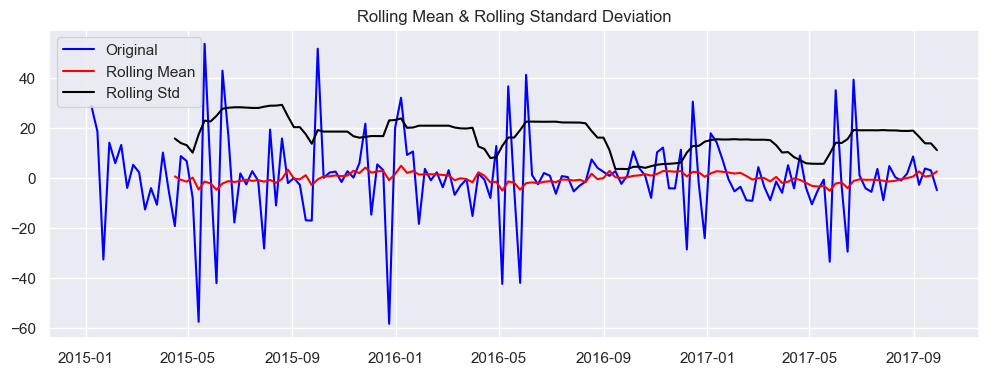

ADF Statistic: -15.4706
p-value: 0.0000
Critical Values:
	1%: -3.4776, 
	5%: -2.8823, 
	10%: -2.5778, 
Вывод: ряд нестационарен


In [54]:
y_diff = y_train[:].diff(1).dropna()

rolling_mean = y_diff.rolling(window = 15).mean()
rolling_std  = y_diff.rolling(window = 15).std()

plt.figure(figsize=(12,4), dpi=100)

plt.plot(y_diff,       color = 'blue',  label = 'Original')
plt.plot(rolling_mean, color = 'red',   label = 'Rolling Mean')
plt.plot(rolling_std,  color = 'black', label = 'Rolling Std')

plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

result = check_ADF(y_diff)

Ряд стал нестационарен, однако визуально среднее приблизилось к стационарному виду. В  ряду все еще преобладает
сезонная составляющая, и ряд по прежнему не стационарен. Попробуем теперь модель с сезонным дифференцированием.

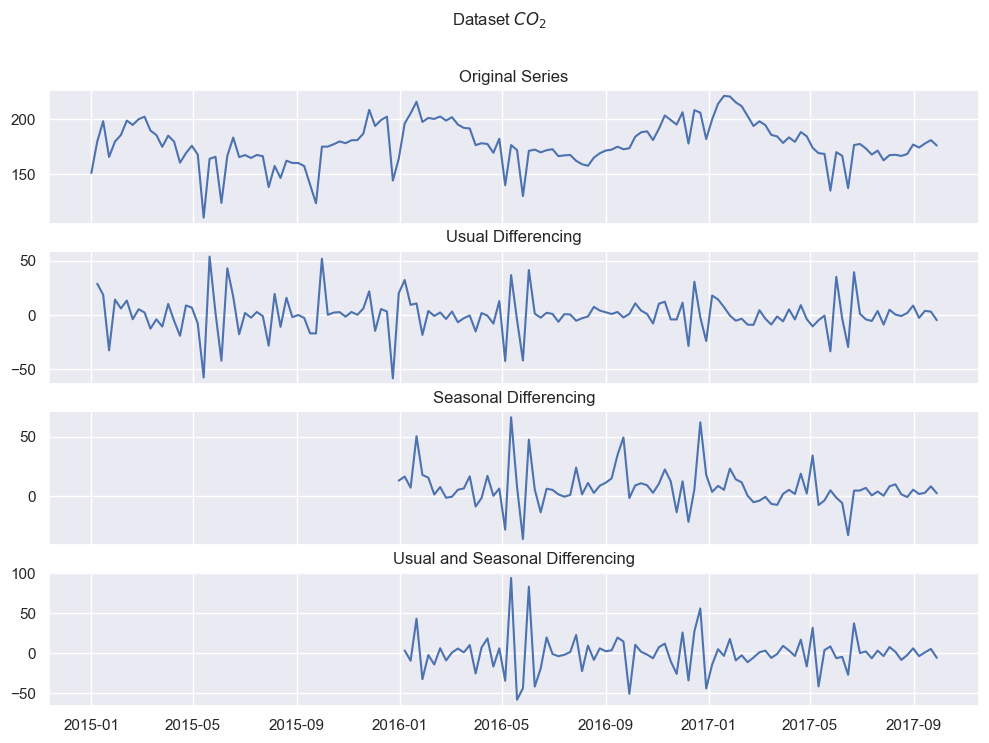

In [55]:
SEASON = 52

# Plot
fig, axes = plt.subplots(4, 1, figsize=(12,8), dpi=100, sharex=True)

# Original Series
axes[0].plot(y_train[:])
axes[0].set_title('Original Series')

# Usual Differencing
axes[1].plot(y_train[:].diff(1))
axes[1].set_title('Usual Differencing')

# Seasinal Differencing
axes[2].plot(y_train[:].diff(SEASON))
axes[2].set_title('Seasonal Differencing')

# Seasinal and Usual Differencing
axes[3].plot(y_train[:].diff(1).diff(SEASON))
axes[3].set_title('Usual and Seasonal Differencing')

plt.suptitle('Dataset $CO_2$', fontsize=12)
plt.show()

В последнем случае мы имеем более стационарный случай. Проверим это при помощи теста.

In [56]:
y_sdif = y_train[:].diff(1).diff(SEASON).dropna()
results = check_ADF(y_sdif);

ADF Statistic: -6.5054
p-value: 0.0000
Critical Values:
	1%: -3.5097, 
	5%: -2.8962, 
	10%: -2.5853, 
Вывод: ряд нестационарен


Хотя тест дал не лучшие результаты, мы можем заключить что предварительной оценкой порядков дифференцирования (интегрирования) являются: $d=1; D=1; s=52$.

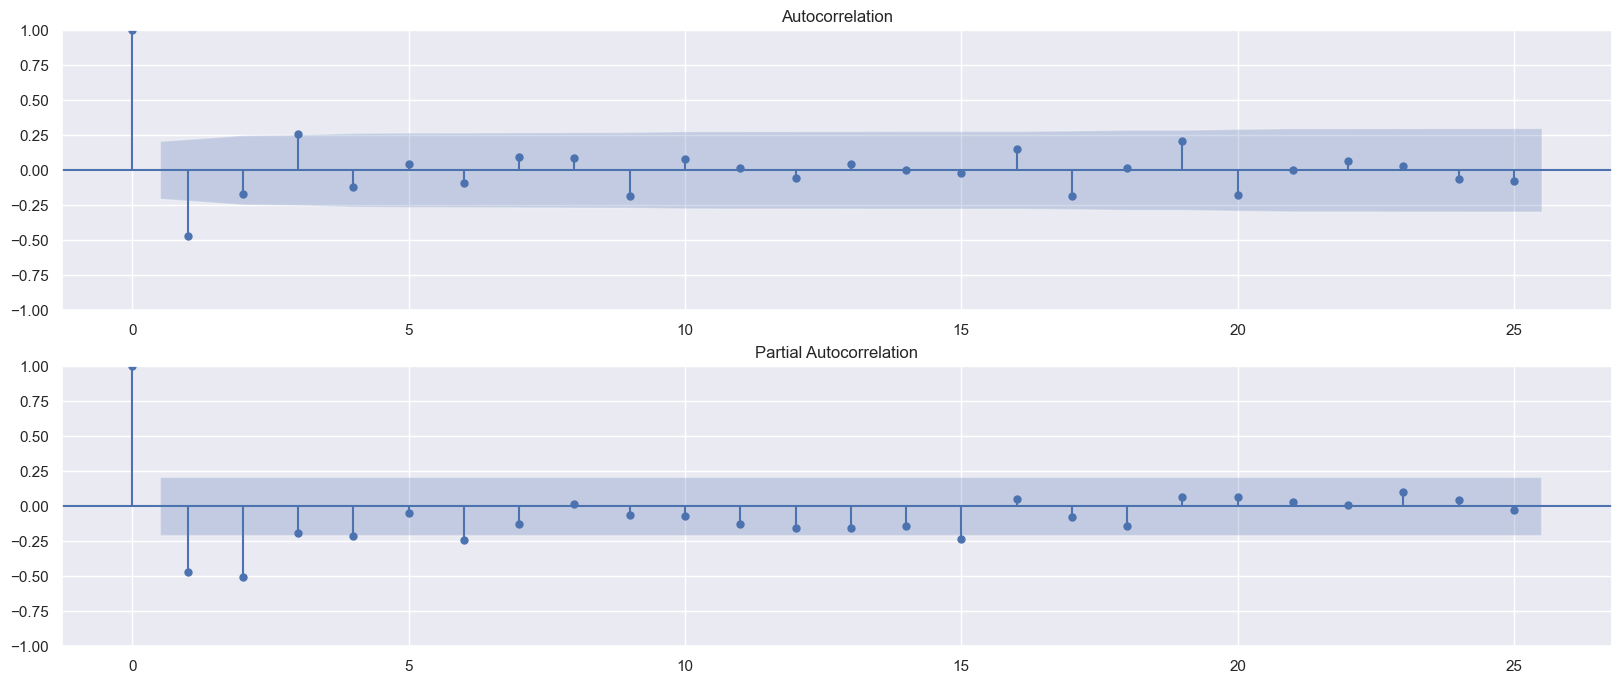

In [57]:
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(y_sdif, lags=25, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(y_sdif, lags=25, ax=ax2)

После двойного дифференцирования вид графиков `ACF` и `PACF` стал намного лучше.
Анализ графика `PACF`показал, что последнее значение лага `PACF` перед быстрым уменьшением от
положительных значений до нуля - 2. Следовательно, количество слагаемых `AR` p=2.
Последнее значение лага `ACF` перед быстрым увеличением от отрицательных значений до нуля-1. Следовательно,количество
  слагаемых скользящего среднего (`MA`) q=1.
  Значимых положительных значений `PACF` нет, поэтому порядок `SAR`=0.
  На `ACF` нет значимых лагов ниже нуля, поэтому порядок `SMA` =0.
  Ряд немного недодифференцирован, поэтому установим порядок `AR`p=3.
  s=52
  Проверим полученную модель $SARIMA (3,1,0)(0,1,0)52.$ . В данном случае мы будем рассматривать класс `SARIMAX` из
  пакета `SKTime`.

In [59]:
forecaster = SARIMAX(order=(3, 2, 1), seasonal_order=(0, 1, 0, 52))
forecaster.fit(y_train);
print(forecaster.summary());

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.80270D+00    |proj g|=  1.09222D-01

At iterate    5    f=  2.74262D+00    |proj g|=  4.09468D-02

At iterate   10    f=  2.70943D+00    |proj g|=  5.36493D-02

At iterate   15    f=  2.70034D+00    |proj g|=  8.54450D-05

At iterate   20    f=  2.70034D+00    |proj g|=  8.03997D-04

At iterate   25    f=  2.70027D+00    |proj g|=  1.25840D-03

At iterate   30    f=  2.70025D+00    |proj g|=  5.50419D-04

At iterate   35    f=  2.70025D+00    |proj g|=  1.32490D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

Критерий качества AIC =789.672. Проведем диагностику остатков графическим способом

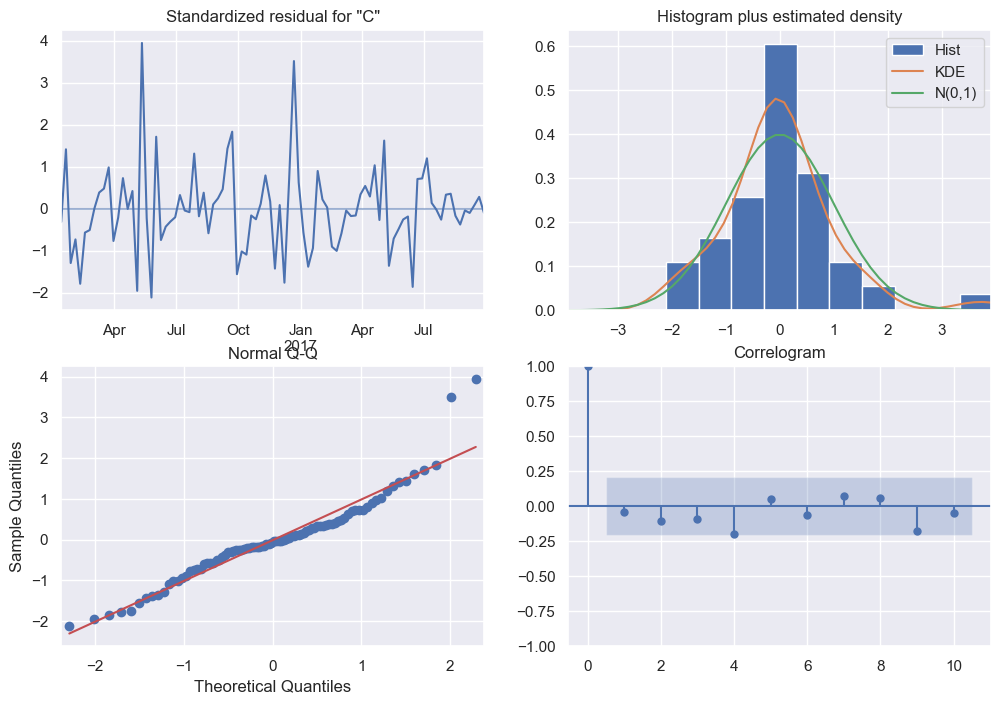

In [60]:
forecaster._fitted_forecaster.plot_diagnostics(figsize=(12,8));

На графиках выше мы видим:
* *верхний левый  график*: остаточные ошибки колеблются около нулевого среднего.
* *верхний правый график*: остаток имеет распределение, похожее на нормальное распределение, но с большими "хвостами".
* *нижний левый график*: график `Q-Q` показывает незначительные отклонения от нормального распределения.
* *нижний правый график*: автокорреляционная функция не показывает значительных (статистически значимых) отличий от нормального распределения.
Визуализируем предсказания нашей модели.

sMAPE = 0.140


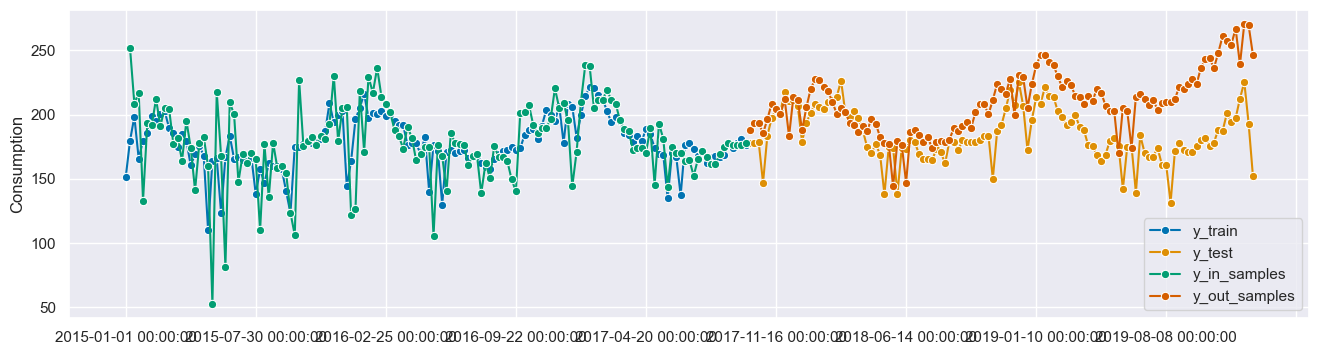

In [61]:
fhin = ForecastingHorizon(y_train.index[1:], is_relative=False)
y_in_samples = forecaster.predict(fhin)

fhout = ForecastingHorizon(y_test.index, is_relative=False)
y_out = forecaster.predict(fhout)

plot_series(y_train, y_test, y_in_samples, y_out, labels=["y_train", "y_test", "y_in_samples", "y_out_samples"]);

print(f'sMAPE = {smape(y_out.values, y_test.values):.3f}')

Полученный результат хуже, чем при использовании более простых методов.
 Оценим предсказание дисперсии.

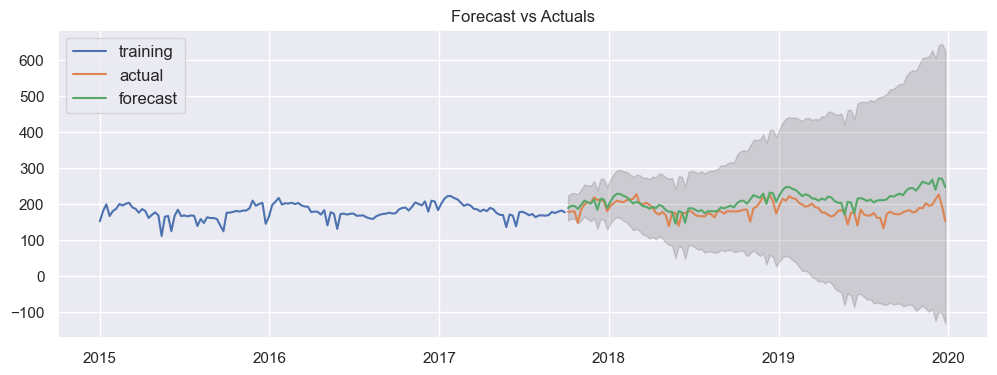

In [62]:
forecast_res = forecaster._fitted_forecaster.get_forecast(y_test.size, alpha=0.01, dynamic=False)  # 95% conf

forecast = forecast_res.predicted_mean

# Make as pandas series
fc_series = pd.Series(forecast.values, index=y_test.index)

lower_series = pd.Series(forecast_res.conf_int()['lower Consumption'], index=y_test.index)
upper_series = pd.Series(forecast_res.conf_int()['upper Consumption'], index=y_test.index)

# Plot
plt.figure(figsize=(12,4), dpi=100)

plt.plot(y_train, label='training')
plt.plot(y_test,  label='actual')
plt.plot(fc_series, label='forecast')

plt.fill_between(lower_series.index,
                 lower_series,
                 upper_series,
                 color='k',
                 alpha=0.15)

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=12)
plt.show()

Полученная модель оказалась неустойчивой в отношении дисперсии. Такую модель использовать нельзя.
Проведенный анализ показывает, что мы должны улучшить нашу модель.
Объект класса `AutoARIMA` позволяет задать границы поиска параметров моделей, а также метод тестирования и ряд других
 параметров. Попробуем найти автоматическое предложение параметров.

In [63]:
model = AutoARIMA(start_p=1,  # начальный порядок AR
                  d=1,        # Порядок производной
                  start_q=0,  # начальный порядок MA
                  max_p=5,    # конечный порядок AR
                  max_q=5,    # конечный порядок MA
                  seasonal=True,  # Использовать SARIMA
                  start_P=0,  # начальный порядок SAR
                  start_Q=0,  # начальный порядок SMA
                  D=1,        # Порядок сезонной производной
                  sp=52,      # Период сезонности
                  max_order = 7, # Максимальный порядок p+q+P+Q
                  trace  = True,   # отчет он-лайн
                  stepwise = True, # метод ускоренного выбора параметров.
                  n_jobs = 1,      # для stepwise парралелизм не доступен.
                  error_action='ignore',
                  suppress_warnings=True)

model.fit(y_train)

model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,0)(0,1,0)[52] intercept   : AIC=815.162, Time=0.26 sec
 ARIMA(0,1,0)(0,1,0)[52] intercept   : AIC=836.005, Time=0.57 sec
 ARIMA(1,1,0)(1,1,0)[52] intercept   : AIC=816.277, Time=2.06 sec
 ARIMA(0,1,1)(0,1,1)[52] intercept   : AIC=inf, Time=6.13 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=834.007, Time=0.46 sec
 ARIMA(1,1,0)(0,1,1)[52] intercept   : AIC=816.277, Time=2.16 sec
 ARIMA(1,1,0)(1,1,1)[52] intercept   : AIC=818.277, Time=2.42 sec
 ARIMA(2,1,0)(0,1,0)[52] intercept   : AIC=790.197, Time=0.61 sec
 ARIMA(2,1,0)(1,1,0)[52] intercept   : AIC=789.374, Time=3.85 sec
 ARIMA(2,1,0)(2,1,0)[52] intercept   : AIC=inf, Time=29.18 sec
 ARIMA(2,1,0)(1,1,1)[52] intercept   : AIC=791.373, Time=4.07 sec
 ARIMA(2,1,0)(0,1,1)[52] intercept   : AIC=789.373, Time=3.19 sec
 ARIMA(2,1,0)(0,1,2)[52] intercept   : AIC=791.374, Time=8.10 sec
 ARIMA(2,1,0)(1,1,2)[52] intercept   : AIC=inf, Time=35.10 sec
 ARIMA(3,1,0)(0,1,1)[52] intercept   : AIC=

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  144
Model:             SARIMAX(2, 1, 2)x(0, 1, [], 52)   Log Likelihood                -382.143
Date:                             Thu, 18 Jan 2024   AIC                            774.286
Time:                                     15:21:50   BIC                            786.841
Sample:                                 01-01-2015   HQIC                           779.351
                                      - 09-28-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7599      0.276     -2.748      0.006      -1.302      -0.218
ar.L2         -0.2081      0.117     -1.775      0.076      -0.438       0.022
ma.L1         -0.2287      0.274     -0.835      0.404      -0.766       0.308
ma.L2         -0.6775      0.307     -2.206      0.027      -1.279      -0.076
sigma2       252.5756     28.075      8.997      0.000     197.550     307.601
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                52.26
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               0.40   Skew:                             1.02
Prob(H) (two-sided):                  0.01   Kurtosis:                         6.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Лучшая модель ARIMA(2,1,2)(0,1,0)[52] с AIC=774.286. Протестируем модель, выбранную автоматически.

In [64]:
forecaster = SARIMAX(order=(2, 1, 2), seasonal_order=(0, 1, 0, 52))
forecaster.fit(y_train);
print(forecaster.summary());

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.67317D+00    |proj g|=  4.90164D-02

At iterate    5    f=  2.65238D+00    |proj g|=  2.25411D-02


 This problem is unconstrained.



At iterate   10    f=  2.64827D+00    |proj g|=  4.15731D-03

At iterate   15    f=  2.64613D+00    |proj g|=  7.19404D-04

At iterate   20    f=  2.64608D+00    |proj g|=  6.51356D-04

At iterate   25    f=  2.64592D+00    |proj g|=  5.50828D-04

At iterate   30    f=  2.64589D+00    |proj g|=  4.80890D-04

At iterate   35    f=  2.64589D+00    |proj g|=  1.40414D-04

At iterate   40    f=  2.64589D+00    |proj g|=  2.77334D-04

At iterate   45    f=  2.64589D+00    |proj g|=  8.10232D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     45     51      1     0     0   8.102D-06   2.646D+00
  F =   2.64588772306

sMAPE = 0.066


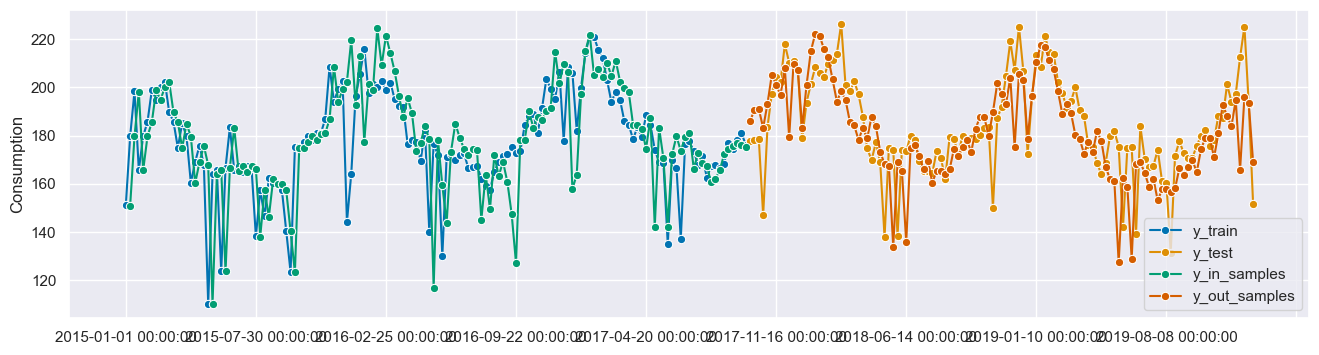

In [65]:
fhin = ForecastingHorizon(y_train.index[1:], is_relative=False)
y_in_samples = forecaster.predict(fhin)

fhout = ForecastingHorizon(y_test.index, is_relative=False)
y_out = forecaster.predict(fhout)

plot_series(y_train, y_test, y_in_samples, y_out, labels=["y_train", "y_test", "y_in_samples", "y_out_samples"]);

print(f'sMAPE = {smape(y_out.values, y_test.values):.3f}')

Остатки:

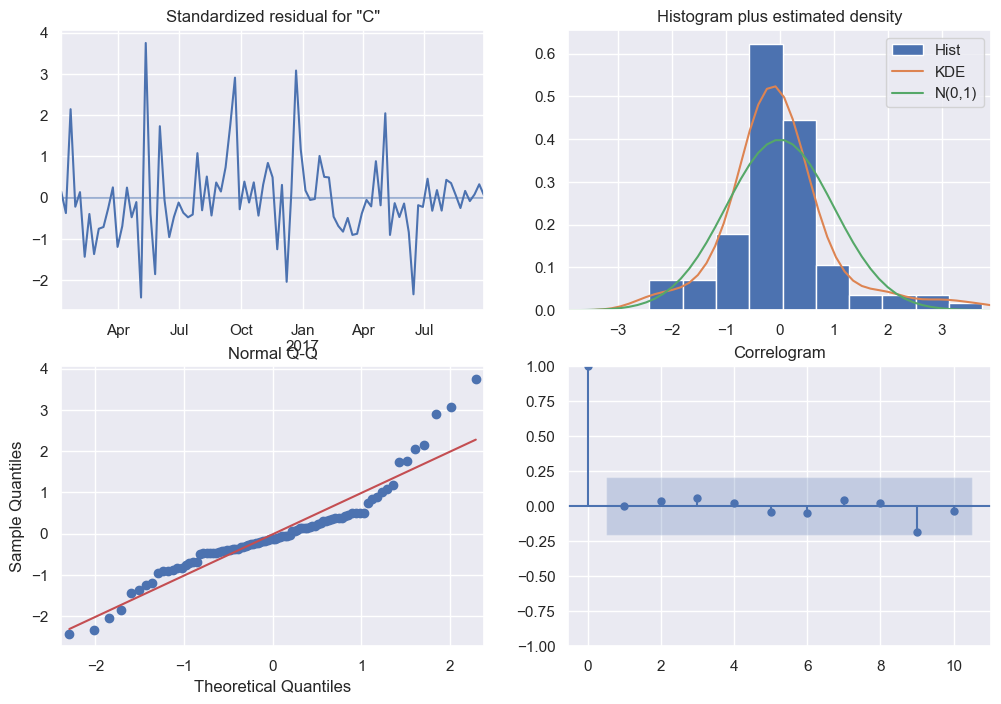

In [66]:
forecaster._fitted_forecaster.plot_diagnostics(figsize=(12,8));

Полученная модель оказалась лучше найденной вручную.

## Общие выводы

Лучшими методами прогнозирования по-прежнему остаются наивное предсказание со стратегией "среднее
значение" (mean) и сезонностью 52 (sMAPE= 0.056) и Prophet (sMAPE = 0.056). Автоматически настроенная модель SARIMA
показала немного худшие результаты (sMAPE = 0.066).

# 7. Классификация

Задача классификации: определение времени года. Для этого необходимо определить дневное потребление электроэнергии в разное время года.

## 7.1. Подготовка данных

Подготовим данные.

In [67]:
dfd = transform_dataframe_by_day(df_hrly)
dfd.to_csv('data_daily.csv')
dfd.head()

Consumption
Date                                  
2015-01-01 00:00:00+00:00        5.946
2015-01-01 01:00:00+00:00        5.726
2015-01-01 02:00:00+00:00        5.347
2015-01-01 03:00:00+00:00        5.249
2015-01-01 04:00:00+00:00        5.309

In [68]:
dfd.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43824 entries, 2015-01-01 00:00:00+00:00 to 2019-12-31 23:00:00+00:00
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Consumption  43824 non-null  float64
dtypes: float64(1)
memory usage: 684.8 KB


Разделим все данные на 4 сезона (зима, весна, осень, лето) и создадим сегменты размером 24 часа (1 день).

(450, 24) (459, 24) (454, 24) (459, 24)


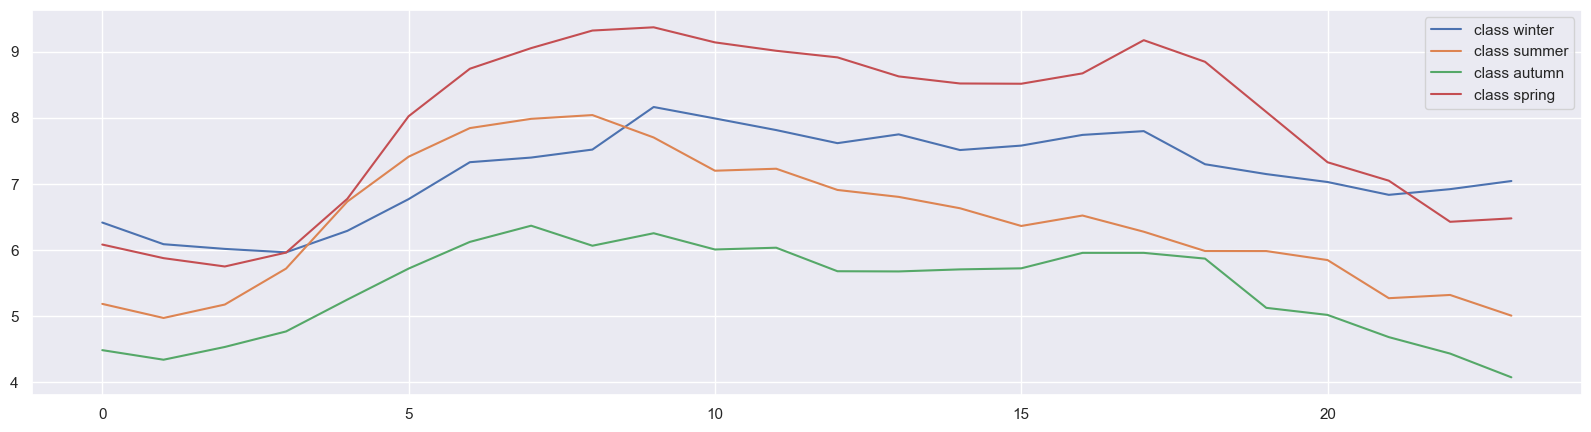

In [70]:
winter = to_segments(split_by_month(dfd, [1,2, 12]), 'Consumption', size = 24)
summer = to_segments(split_by_month(dfd, [6, 7, 8]), 'Consumption', size = 24)
autumn = to_segments(split_by_month(dfd, [9,10,11]), 'Consumption', size = 24)
spring = to_segments(split_by_month(dfd, [3, 4, 5]), 'Consumption', size = 24)
print(winter.shape, summer.shape, autumn.shape, spring.shape)
plt.figure()
day = 10
for i,(c,d) in enumerate(zip([winter,summer,autumn,spring],['winter','summer','autumn','spring'])):
    plt.plot(c[day], label="class " + str(d))
plt.legend(loc="best")
plt.show()

Cоздадим массив тренировочных и тестовых данных.

In [71]:
X = np.concatenate((
                    winter,
                    summer,
                    autumn,
                    spring))
y = np.concatenate((
                    0*np.ones(winter.shape[0]),
                    1*np.ones(summer.shape[0]),
                    2*np.ones(autumn.shape[0]),
                    3*np.ones(spring.shape[0])
                   ))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1275, 24) (1275,) (547, 24) (547,)


Не все функции `SKTime` поддерживают `2d ndarray` поэтому создадим `nested_univ` копии данных.

In [72]:
df_train = convert_to(np.atleast_3d(X_train).transpose(0,2,1), to_type="nested_univ")
df_test  = convert_to(np.atleast_3d(X_test ).transpose(0,2,1), to_type="nested_univ")

## 7.2. Классификация
### Классификация sklearn

In [73]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
print(f' test score {clf.score(X_test, y_test):.3f}')

 test score 0.781


### Классификация на основе данных

In [74]:
clf = KNeighborsTimeSeriesClassifier(n_neighbors=1, distance="ddtw")
clf.fit(X_train, y_train)
print(f' test score {clf.score(X_test, y_test):.3f}')

 test score 0.777


In [75]:
clf = ShapeletTransformClassifier(estimator=RandomForestClassifier(n_estimators=100),
                                  n_shapelet_samples=100,
                                  max_shapelets=100,
                                  batch_size=20)

clf.fit(X_train, y_train)
print(f' test score {clf.score(X_test, y_test):.3f}')

 test score 0.757


In [76]:
clf = MUSE(random_state=47)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.8482632541133455

### Классификаторы на основе признаков

In [77]:
clf = SupervisedTimeSeriesForest(n_estimators=100, random_state=47)
clf.fit(X_train, y_train)
print(f' test score {clf.score(X_test, y_test):.3f}')

 test score 0.848


Выводы
Все методы справились не очень хорошо:
Классификатор `случайный лес` из `sklearn` - test score = 0.781.
Алгоритм `k-соседей` из пакета `SKTime` - test score = 0.777.
Классификатор на основе шейплетов из пакета `SKTime` для работы со словарями `MUSE` - test score = 0.848.
Классификатор `SupervisedTimeSeriesForest` на основе признаков из пакета `SKTime` - test score = 0.848.
Два последних метода показали одинаковый результат. Однако поскольку следует отдавать предпочтения классификаторам на
основе признаков, то рекомендуемым в данном случае будет метод SupervisedTimeSeriesForest из пакета `SKTime`.

## 7.3. Классификация при помощи глубоких нейронных сетей

### Подготовка данных

In [78]:
computer_setup()

os              : Linux-6.2.0-33-generic-x86_64-with-glibc2.35
python          : 3.10.12
tsai            : 0.3.8
fastai          : 2.7.13
fastcore        : 1.5.29
torch           : 2.1.2+cu121
device          : 1 gpu (['NVIDIA GeForce RTX 4050 Laptop GPU'])
cpu cores       : 10
threads per cpu : 1
RAM             : 38.93 GB
GPU memory      : [6.0] GB


In [79]:
#Xn = convert_to(np.atleast_3d(X).transpose(0,2,1), to_type="nested_univ")
Xn = np.atleast_3d(X).transpose(0,2,1)

Сопоставим названия классов и их номера

In [80]:
season_class_map = {
    0:'winter',
    1:'summer',
    2:'autumn',
    3:'spring',
    }
season_class_map

{0: 'winter', 1: 'summer', 2: 'autumn', 3: 'spring'}

In [83]:
labeler = ReLabeler(season_class_map)
yn = labeler(y)

Создадим разделение набора данных на тренировочную, валидационную и тестовую подвыборки.

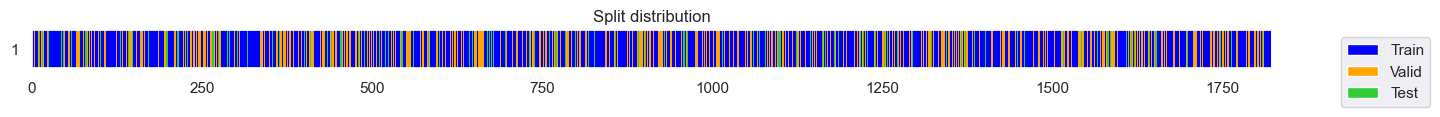

((#1094) [1634,837,895,1196,613,724,1093,1593,598,1688...],
 (#546) [1679,1784,1332,1084,253,401,1579,553,1017,856...],
 (#182) [453,338,675,1547,88,826,171,214,980,1619...])

In [87]:
splits = get_splits(yn,
                    n_splits=1,
                    valid_size=0.3,
                    test_size=0.1,
                    shuffle=True,
                    balance=False,
                    stratify=True,
                    random_state=42,
                    show_plot=True,
                    verbose=True)
splits


Создадим набор данных. Такой набор будет экземпляром класса `TSDatasets`. В наборе данных зададим разделение данных и
 необходимые преобразования `tfms`.

In [88]:
tfms  = [None, [Categorize()]]
dsets = TSDatasets(Xn, yn, tfms=tfms, splits=splits)

Сконфигурируем загрузчик батчей `TSDataLoaders`. Загрузим тренировочный и валидационный наборы данных.

In [89]:
bs = 256
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[bs, bs*2])

Среди анализируемых архитектур мы рассмотрим рекуррентные `RNN`, `LSTM` и `GRU` ячейки в двух вариантах обычном и
плюс. Для обоих вариантов мы рассмотрим архитектуры с 3 и 4 слоями, как двунаправленные, так и нет. Кроме рекуррентных нейронных сетей мы также попробуем ряд стандартных сверточных архитектур, таких как `ResNet1d`, `xresnet1d`, `InceptionTime `, `XceptionTime` и `TCN`.

In [90]:
archs = [
         (RNNPlus, {'n_layers':3, 'bidirectional': True} ),
         (LSTMPlus,{'n_layers':3, 'bidirectional': True} ),
         (GRUPlus, {'n_layers':3, 'bidirectional': True} ),
         (RNNPlus, {'n_layers':4, 'bidirectional': True} ),
         (RNNPlus, {'n_layers':4, 'bidirectional': False}),
         (LSTM,    {'n_layers':3, 'bidirectional': False}),
         (RNN,     {'n_layers':3, 'bidirectional': True} ),
         (LSTM,    {'n_layers':3, 'bidirectional': True} ),
         (GRU,     {'n_layers':3, 'bidirectional': True} ),
         (ResNet, {}),
         (xresnet1d34, {}),
         (xresnet1d50_deeper, {}),
         (InceptionTime, {}),
         (XceptionTime,  {}),
         (TCN, {}),
         (LSTM_FCN, {}),
         (TST, {}),
         (FCN, {}),
        ]

Для создания модели используем функцию `create_model`, которая для создает модель в формате совместимом с `PyTorch` для заданной архитектуры и набора гиперпараметров.
В пакете `tsai` обучение проводится для объекта класса `Learner`.

In [35]:
results = pd.DataFrame(columns=['arch', 'hyperparams', 'total params', 'train loss', 'valid loss', 'accuracy', 'time'])

for i, (arch, k) in enumerate(archs):
    try:
        model = create_model(arch, dls=dls, **k)
        print(model.__class__.__name__)
        learn = Learner(dls, model,  metrics=accuracy)
        start = time.time()
        learn.fit_one_cycle(20, 1e-3)
        elapsed = time.time() - start
        vals = learn.recorder.values[-1]
        results.loc[i] = [arch.__name__, k, count_parameters(model), vals[0], vals[1], vals[2], int(elapsed)]
    except TypeError as e:
        print ("Error:", e)
        continue

clear_output()
results.sort_values(by='accuracy', ascending=False, ignore_index=True, inplace=True)
display(results)

arch                              hyperparams  total params  \
0          ResNet                                       {}        478724   
1   InceptionTime                                       {}        388868   
2         RNNPlus   {'n_layers': 4, 'bidirectional': True}        202604   
3    XceptionTime                                       {}        399480   
4             FCN                                       {}        264580   
5        LSTM_FCN                                       {}        315380   
6         RNNPlus   {'n_layers': 3, 'bidirectional': True}        142204   
7             TST                                       {}        411524   
8         RNNPlus  {'n_layers': 4, 'bidirectional': False}         71304   
9             RNN   {'n_layers': 3, 'bidirectional': True}        142204   
10        GRUPlus   {'n_layers': 3, 'bidirectional': True}        425004   
11            GRU   {'n_layers': 3, 'bidirectional': True}        425004   
12           LSTM   {'n_layers': 3, 'bidirectional': True}        566404   
13       LSTMPlus   {'n_layers': 3, 'bidirectional': True}        566404   
14           LSTM  {'n_layers': 3, 'bidirectional': False}        203204   
15            TCN                                       {}         66754   

    train loss  valid loss  accuracy  time  
0     0.455413    0.410382  0.849817    10  
1     0.519473    0.456310  0.824176    15  
2     0.840307    0.601794  0.776557     8  
3     0.991534    0.915118  0.745421    35  
4     0.849911    0.735622  0.743590     5  
5     0.873934    0.741933  0.738095     6  
6     0.921725    0.740937  0.730769     6  
7     0.881661    0.828783  0.684982    13  
8     0.963532    0.826083  0.683150     3  
9     1.026293    0.889986  0.628205     6  
10    1.196679    1.093189  0.494505    16  
11    1.201343    1.100293  0.489011    16  
12    1.205143    1.110487  0.472527    15  
13    1.200017    1.113572  0.463370    15  
14    1.250504    1.185893  0.459707     6  
15    1.355923    1.325177  0.419414    15

Архитектура `ResNet` дала оптимальный результат, лучший по качеству и приемлимый по времени работы. Рассмотрим эту
архитектуру подробней. Попробуем определить лучшую скорость обучения.

SuggestedLRs(valley=0.001737800776027143)

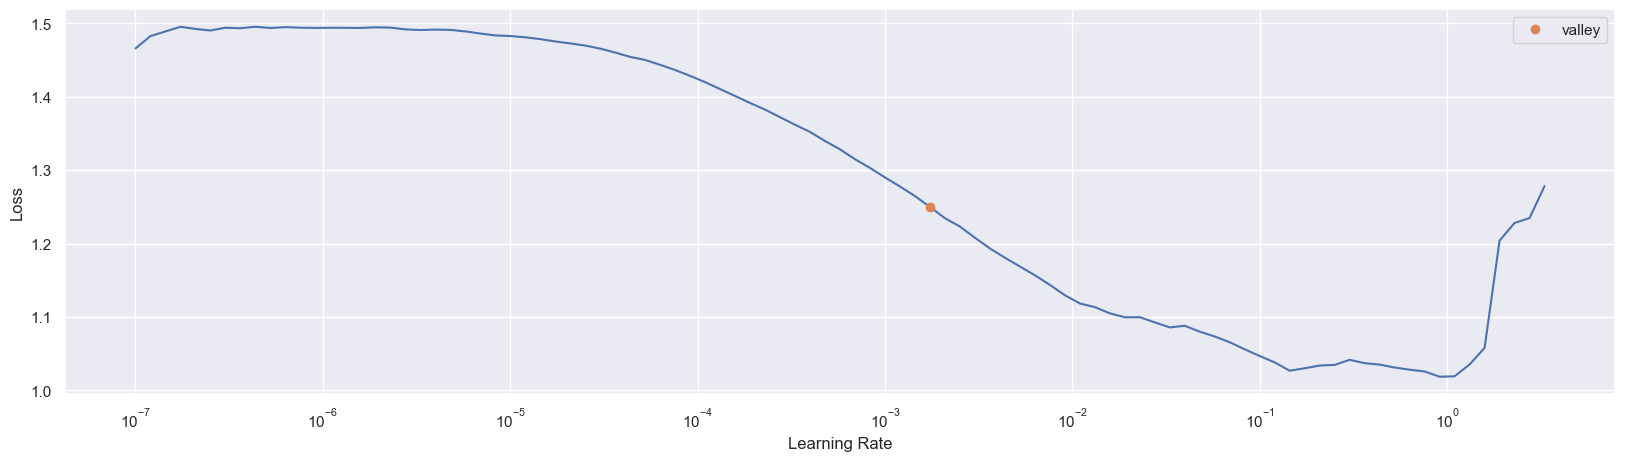

In [91]:
model = build_ts_model(ResNet, dls=dls)
learn = ts_learner(dls, arch=model, metrics=accuracy)
learn.lr_find()

Теперь снова запустим обучение. В этот раз мы запустим процедуру тренировки с коллбеком, позволяющим отслеживать значения функций потерь в режиме он-лайн.

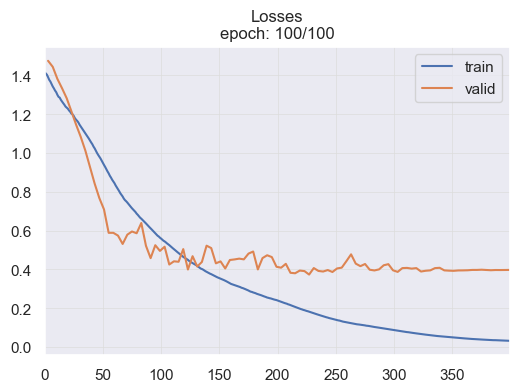

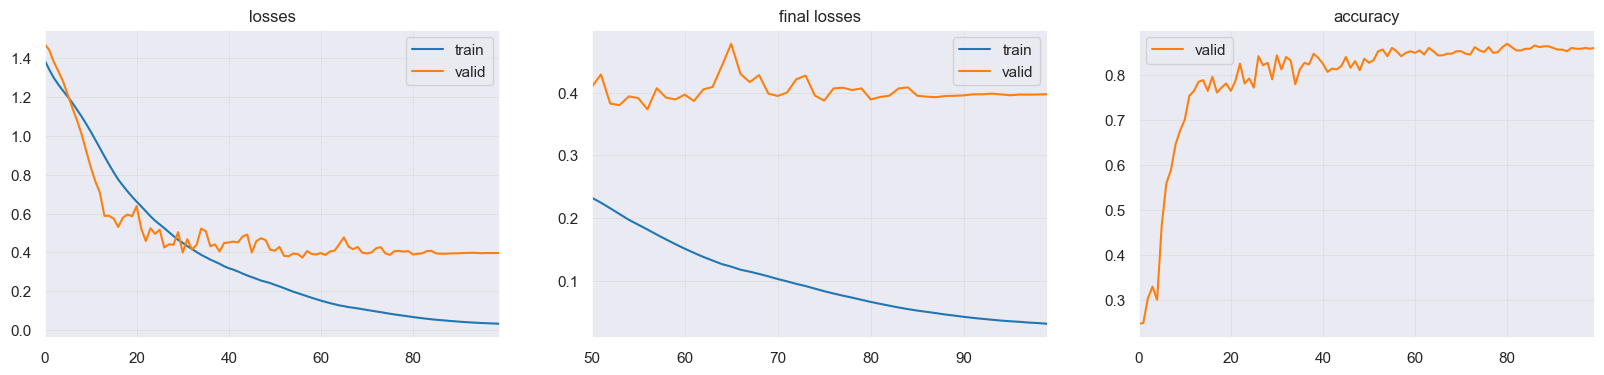

In [92]:
model = build_ts_model(ResNet, dls=dls)
learn = Learner(dls, model,  metrics=accuracy);
learn.fit_one_cycle(n_epoch = 100, lr_max = 0.00069, cbs=ShowGraph());

вероятность при которой определяется класс для каждого семпла валидационной выборки.

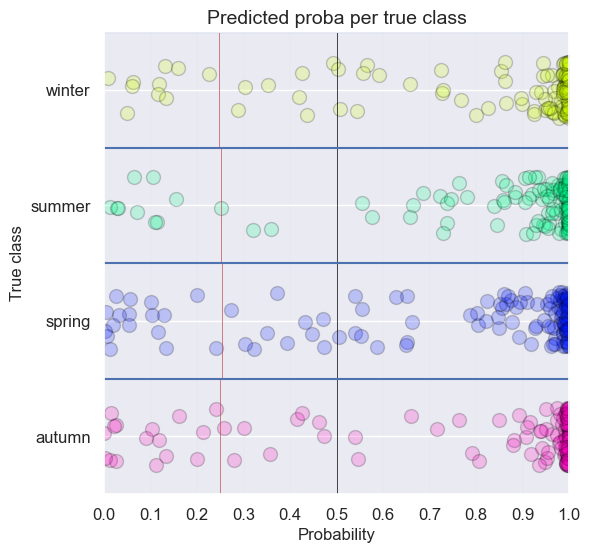

In [93]:
learn.show_probas()

Матрица ошибок

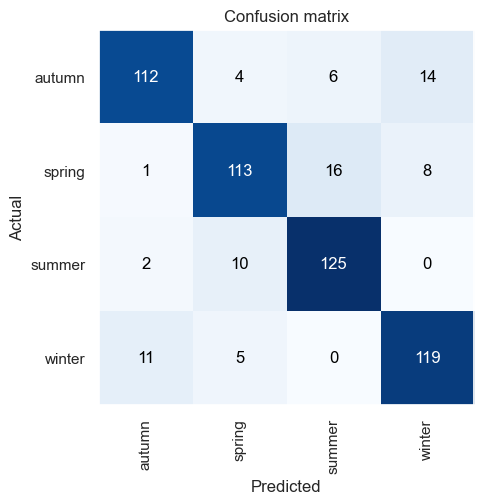

In [94]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Ошибок достаточно много.

In [95]:
probas, _, preds = learn.get_X_preds(Xn[splits[2][:5]])
preds, yn[splits[2][:5]]

("['summer', 'autumn', 'summer', 'spring', 'winter']",
 array(['summer', 'winter', 'summer', 'spring', 'winter'], dtype='<U6'))

Оценим точность на тестовом наборе данных

In [96]:
probas, _, preds = learn.get_X_preds(Xn[splits[2]]);

In [97]:
season_class_map2 = {
    'winter':3,
    'summer':2,
    'autumn':0,
    'spring':1,
    }
season_class_map2

{'winter': 3, 'summer': 2, 'autumn': 0, 'spring': 1}

In [98]:
labeler = ReLabeler(season_class_map2)
from sklearn.metrics import accuracy_score

accuracy_score(np.argmax(probas,axis=-1), labeler(yn[splits[2]]))

0.8626373626373627

Вывод: Классификатор на основе глубоких нейронных сетей с архитектурой `ResNet`показал чуть лучший результат, чем классификаторы `MUSE` и `SupervisedTimeSeriesForest` из предыдущего раздела, однако учитывая реурсоемкость методов классификации, препочтение следует отдать методу `SupervisedTimeSeriesForest` на основе признаков из пакета `SKTime`

# 8. Аномалии

Скользящее средние и СКО

<Axes: xlabel='Date'>

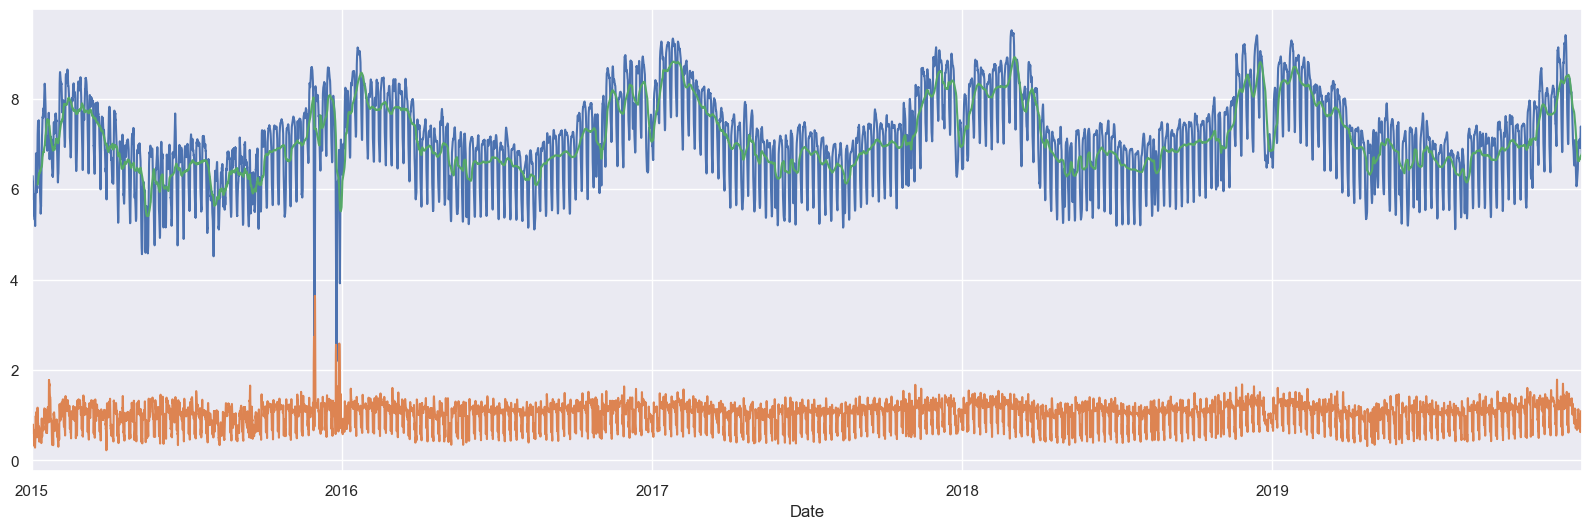

In [99]:
plt.rc('figure',figsize=(20,6))
plt.rc('font',size=15)
# create moving-averages
dfd.Consumption.rolling(24).mean().plot()
dfd.Consumption.rolling(24).std().plot()
dfd.Consumption.rolling(24*7).mean().plot()

Дифференцирование

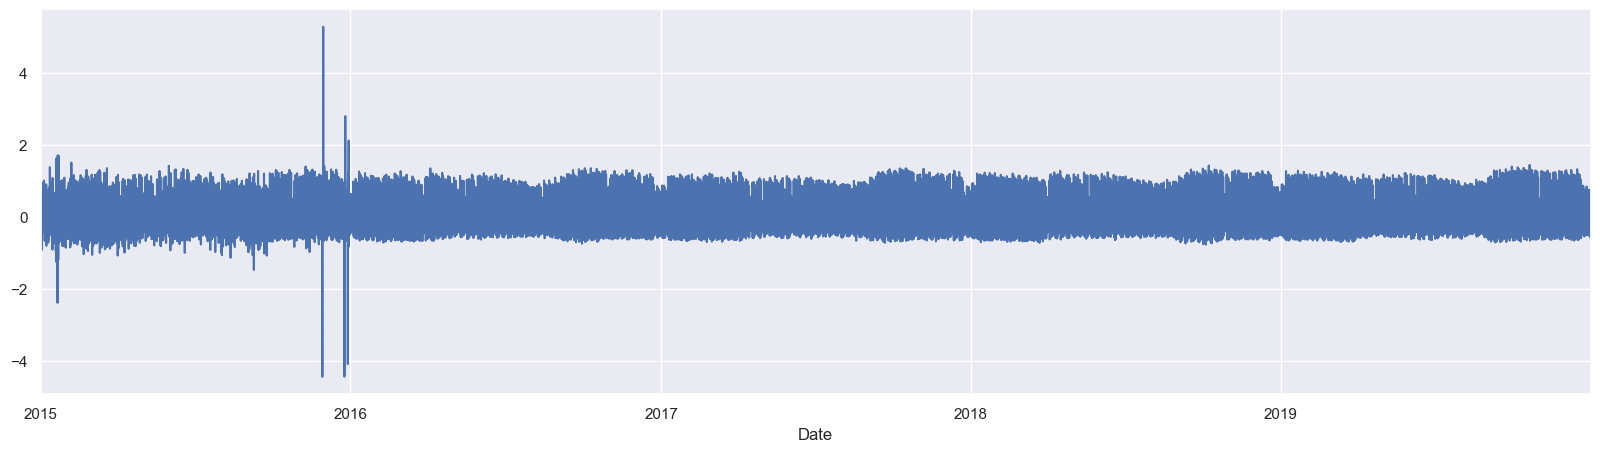

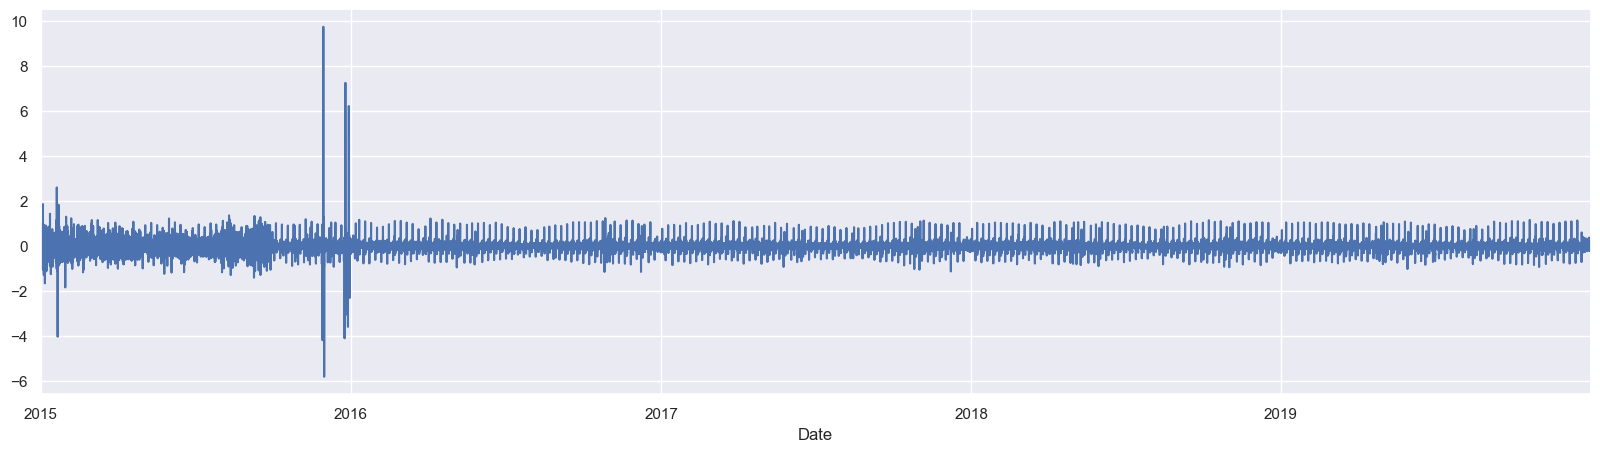

In [100]:
plt.rc('figure',figsize=(20,5))
plt.rc('font',size=15)

dfd.Consumption.diff(1).plot(); plt.show()
dfd.Consumption.diff(24).diff(1).plot(); plt.show()

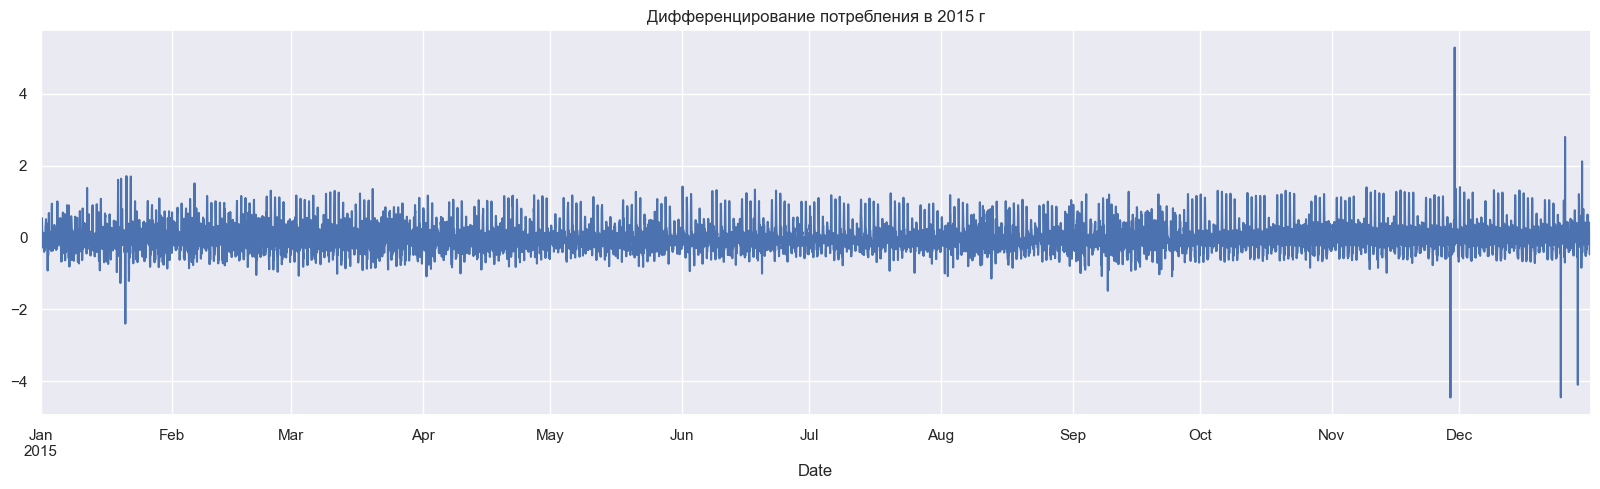

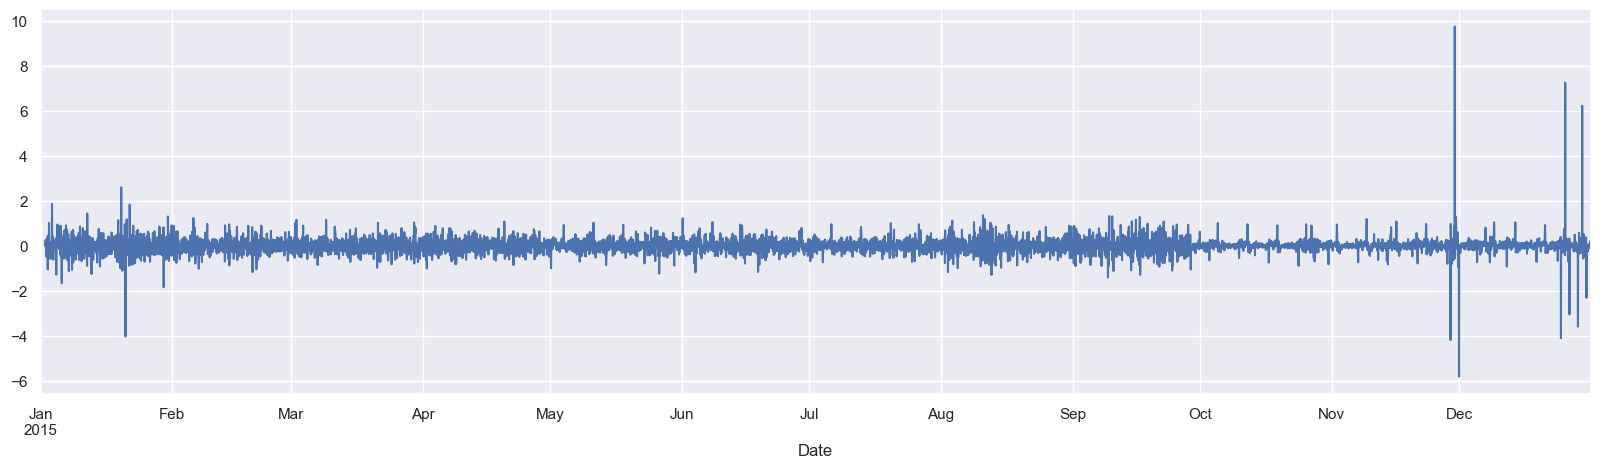

In [101]:
plt.rc('figure',figsize=(20,5))
plt.rc('font',size=15)
plt.title("Дифференцирование потребления в 2015 г")
dfd15=dfd.loc['2015-01-01':'2015-12-31']

dfd15.Consumption.diff(1).plot(); plt.show()
dfd15.Consumption.diff(24).diff(1).plot(); plt.show()

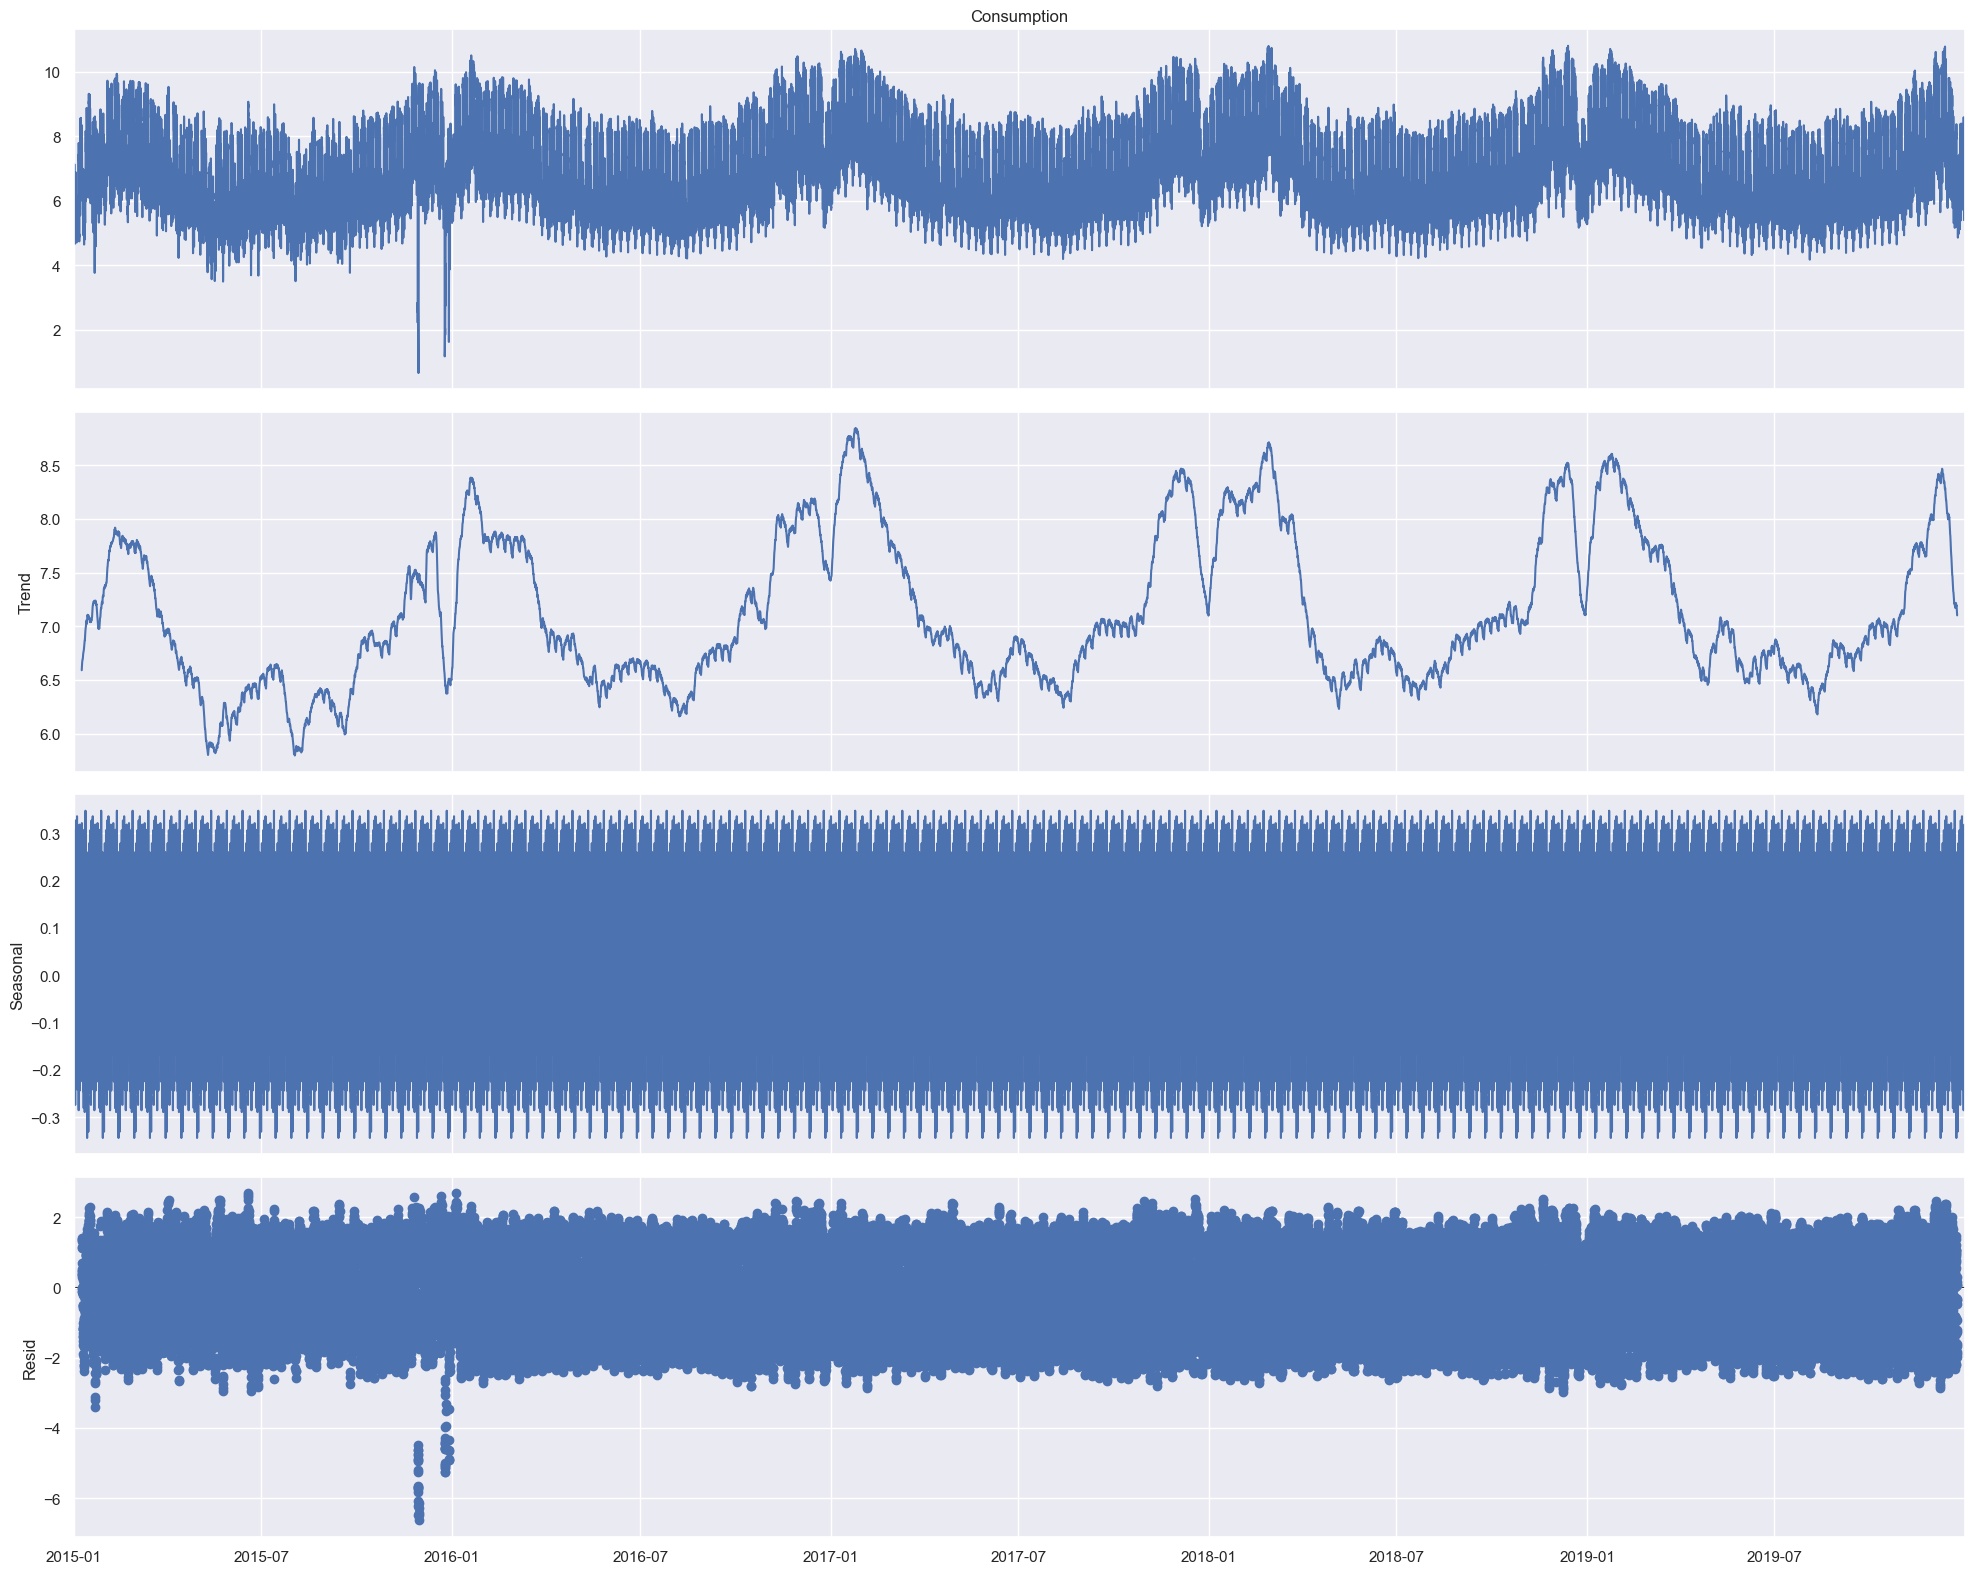

In [102]:
rcParams['figure.figsize'] = 20, 16
decomposition = seasonal_decompose(dfd['Consumption'], model='additive', period = 364)
fig = decomposition.plot()
plt.show()

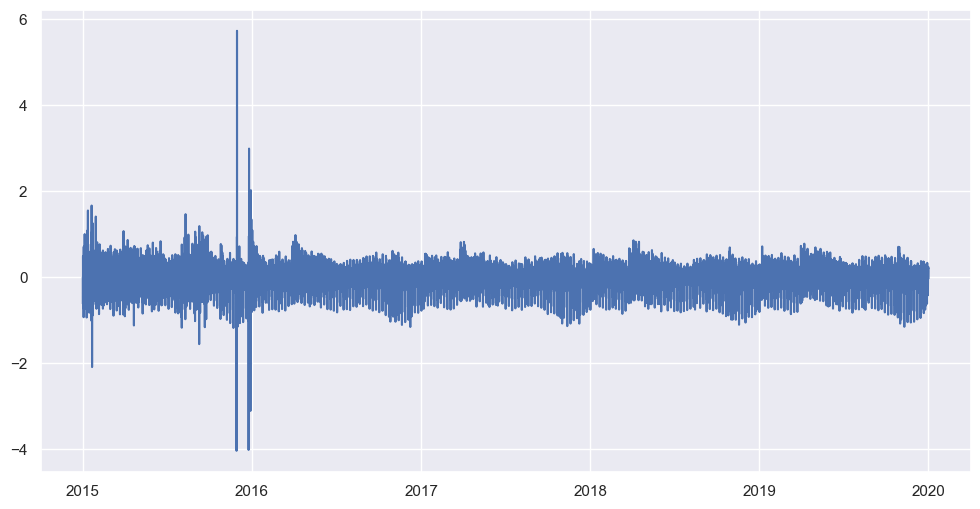

In [103]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

y = dfd['Consumption'].values.reshape(-1, 1)

forecaster = ExponentialSmoothing(y,seasonal_periods=48,trend="add",seasonal="add").fit()
predicts = forecaster.predict(start=0, end=len(y)-1)

plt.rc('figure',figsize=(12,6))
plt.plot(dfd.index, y.reshape(-1) - predicts)

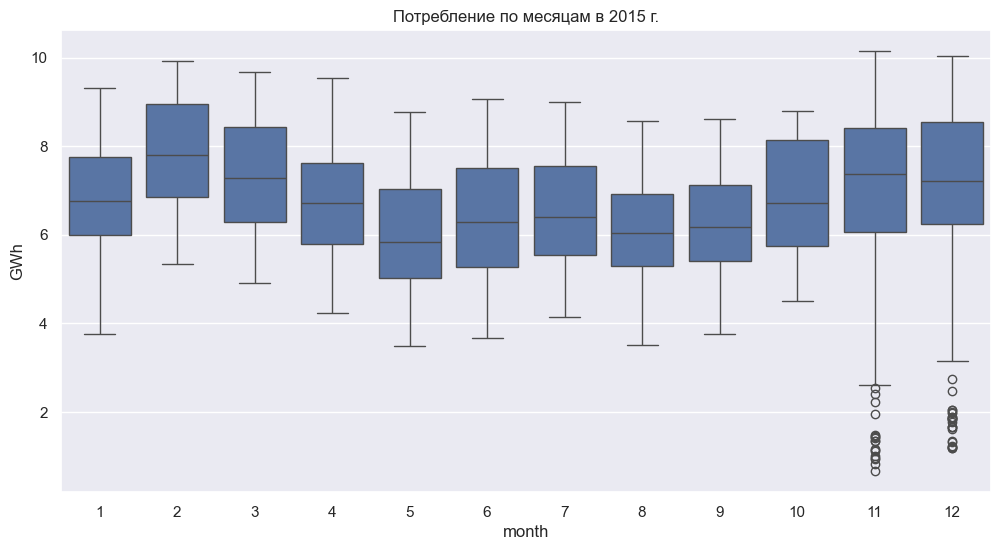

In [104]:
ax = sns.boxplot(data=dfd15, x=dfd15.index.month, y='Consumption')
ax.set_ylabel('GWh')
ax.set_xlabel('month')
ax.set_title('Потребление по месяцам в 2015 г.')
plt.show()

Значения самых значимых выбросов

In [105]:
dfd15.sort_values(by='Consumption', ascending=True, ignore_index=False).head(10)

Consumption
Date                                  
2015-11-29 18:00:00+00:00        0.664
2015-11-29 17:00:00+00:00        0.837
2015-11-29 22:00:00+00:00        0.948
2015-11-29 20:00:00+00:00        0.960
2015-11-29 16:00:00+00:00        1.016
2015-11-29 13:00:00+00:00        1.117
2015-11-29 19:00:00+00:00        1.143
2015-11-29 21:00:00+00:00        1.166
2015-12-25 01:00:00+00:00        1.180
2015-12-25 00:00:00+00:00        1.197

На графиках явно прослеживается наличие выбросов и аномалий.Выбросы четко прослеживаются в 2015 г., особенно сильные
25 декабря и 29 ноября, когда потребление упало до критической низкого значения в 1,18 и 0,6 ГВт соответственно.
Падение длилось несколько часов, и можно предположить, что это было связано с техническим сбоем.
Проанализируем остальные аномалии.

QuantileAD основан на использовании квантилей для выявления аномалий. Высокие и низкие квантили устанавливают верхний и нижний пороги, и точки данных за пределами этих порогов считаются аномалиями.
QuantileAD подходит для обнаружения общих аномалий, не зависящих от времени.

In [108]:
from adtk.detector import QuantileAD
from adtk.visualization import plot as plot2
quantile_ad = QuantileAD(high=0.99, low=0.01)
anomalies = quantile_ad.fit_detect(dfd)
print('Число аномальных выбросов:', anomalies.values.sum())

Число аномальных выбросов: 877


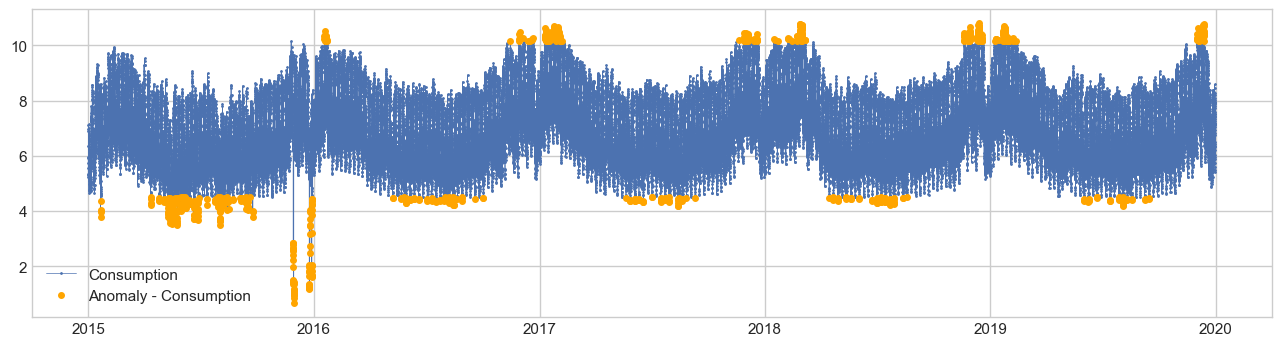

In [109]:
plot2(dfd, anomaly=anomalies, anomaly_color="orange", anomaly_tag="marker");

SeasonalAD предназначен для обнаружения сезонных аномалий, которые повторяются в определенные периоды времени. Метод
использует характерные сезонные паттерны для выявления отклонений. Полезен при поиске аномалий, связанных с сезонными колебаниями.

In [110]:
from adtk.detector import SeasonalAD
seasonal_vol = SeasonalAD()
anomalies = seasonal_vol.fit_detect(dfd.Consumption)
anomalies.value_counts()

Consumption
False    43656
True       168
Name: count, dtype: int64

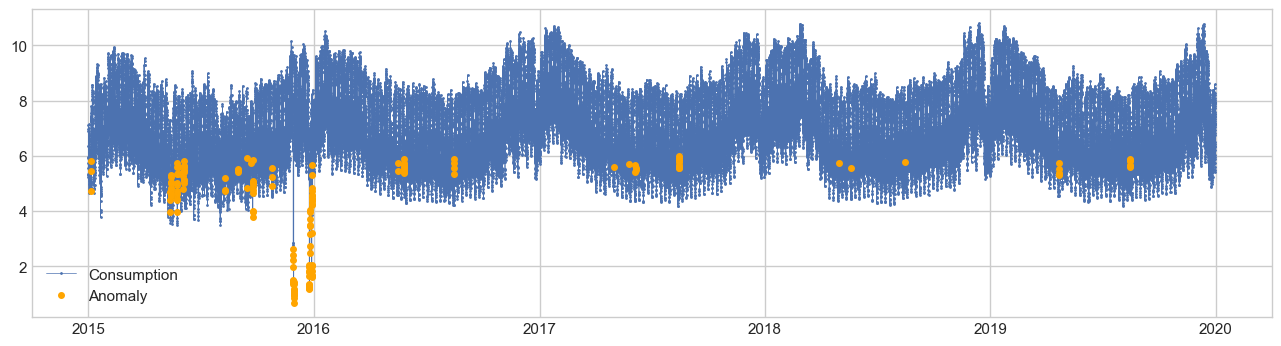

In [111]:
plot2(dfd, anomaly=anomalies, anomaly_color="orange", anomaly_tag="marker");

InterQuartileRangeAD использует межквартильный размах (IQR) для определения аномалий. Он опирается на разницу между
первым и третьим квартилями данных. Подходит для выявления аномалий, не вписывающихся в типичные распределения данных.

In [112]:
from adtk.detector import InterQuartileRangeAD
iqr_ad = InterQuartileRangeAD(c=0.9)
anomalies = iqr_ad.fit_detect(dfd['Consumption'])
anomalies.value_counts()

Consumption
False    43127
True       697
Name: count, dtype: int64

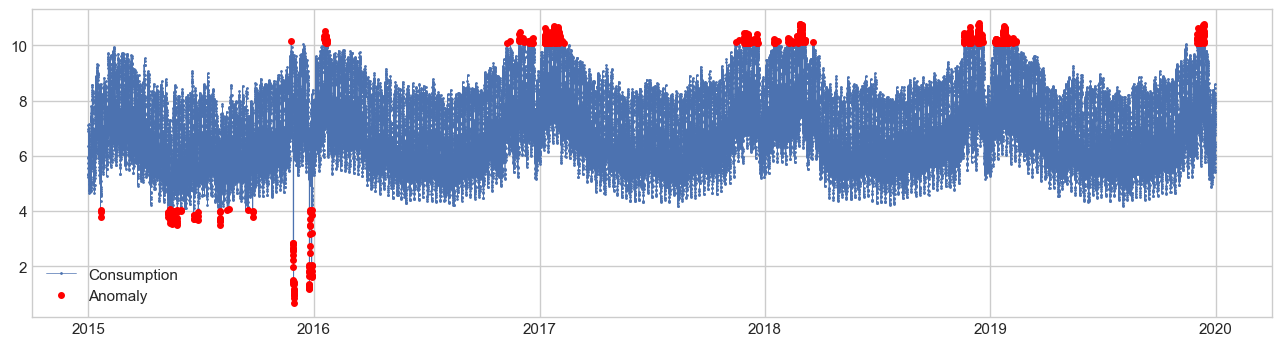

In [113]:
plot2(dfd, anomaly=anomalies, anomaly_color="red", anomaly_tag="marker");

In [114]:
from adtk.detector import VolatilityShiftAD
volatility_shift_ad = VolatilityShiftAD(c=1.0, side='positive', window=30)
anomalies = volatility_shift_ad.fit_detect(dfd)
anomalies.value_counts()

Consumption
False          38899
True            4866
Name: count, dtype: int64

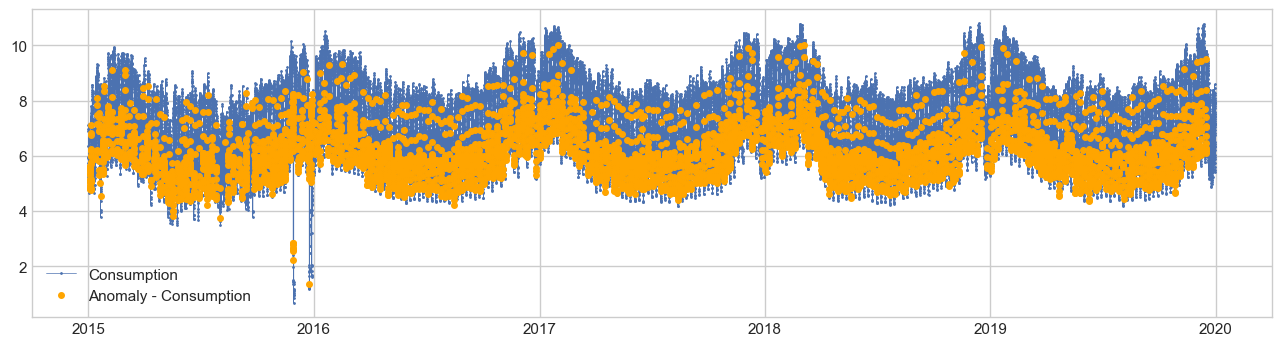

In [115]:
plot2(dfd, anomaly=anomalies, anomaly_color="orange", anomaly_tag="marker");

Изменения значений судя по графику в большинстве носят аномальный характер, поэтому считать это аномалией будет неправильно.

In [116]:
from adtk.detector import LevelShiftAD
level_shift_ad = LevelShiftAD(c=0.2, side='both', window=50)
anomalies = level_shift_ad.fit_detect(dfd)
anomalies.value_counts()

Consumption
False          39081
True            4644
Name: count, dtype: int64

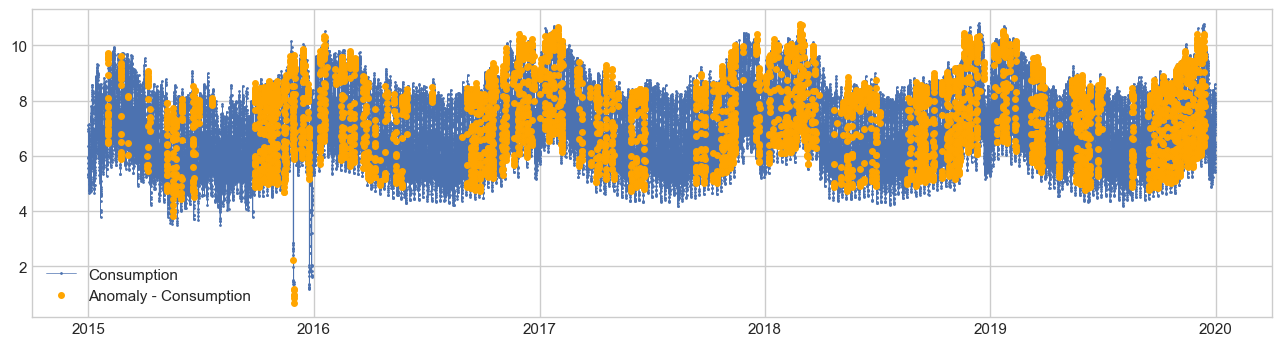

In [117]:
plot2(dfd, anomaly=anomalies, anomaly_color="orange", anomaly_tag="marker");

In [118]:
from sklearn.ensemble import IsolationForest

outliers_fraction = 0.007

model =  IsolationForest(contamination=outliers_fraction)
model.fit(dfd['Consumption'].values.reshape(-1, 1))
y = dfd['Consumption'].values.reshape(-1, 1)
dfd['anomaly_IF'] = model.predict(y)

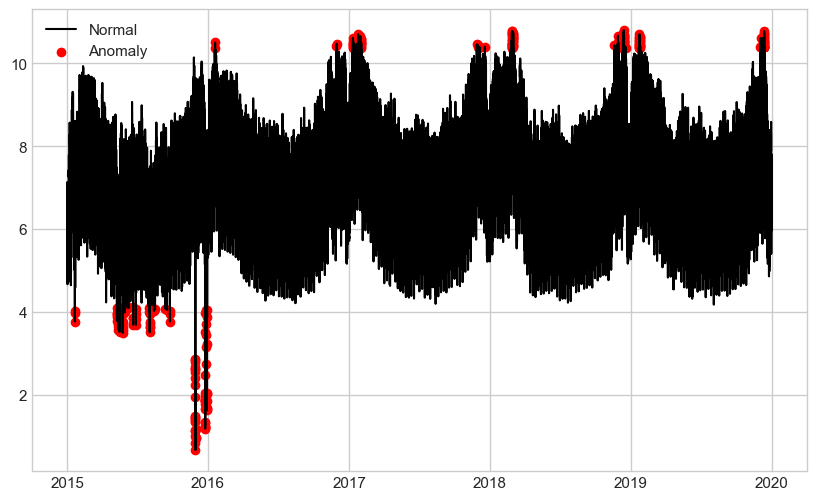

In [119]:
# visualization
fig, ax = plt.subplots(figsize=(10,6))

a = dfd.loc[dfd['anomaly_IF'] == -1, ['Consumption']] #anomaly

ax.plot(dfd.index, dfd['Consumption'], color='black', label = 'Normal')
ax.scatter(a.index,a['Consumption'], color='red', label = 'Anomaly')
plt.legend()
plt.show();

Аномалии в течение года присутствуют и связаны с сезонностью. Наибольшая их концентрация в зимнее время года, что
видимо связано с флуктуацией климата. Также есть небольшие аномалии и в летнее время.